In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.metrics import r2_score

def get_fund_k_history(fund_code: str, pz: int = 1000) -> pd.DataFrame:
    '''
    根据基金代码和要获取的页码抓取基金净值信息

    Parameters
    ----------
    fund_code : 6位基金代码
    page : 页码 1 为最新页数据

    Return
    ------
    DataFrame : 包含基金历史k线数据
    '''
    # 请求头
    EastmoneyFundHeaders = {
        'User-Agent': 'EMProjJijin/6.2.8 (iPhone; iOS 13.6; Scale/2.00)',
        'GTOKEN': '98B423068C1F4DEF9842F82ADF08C5db',
        'clientInfo': 'ttjj-iPhone10,1-iOS-iOS13.6',
        'Content-Type': 'application/x-www-form-urlencoded',
        'Host': 'fundmobapi.eastmoney.com',
        'Referer': 'https://mpservice.com/516939c37bdb4ba2b1138c50cf69a2e1/release/pages/FundHistoryNetWorth',
    }
    # 请求参数
    data = {
        'FCODE': f'{fund_code}',
        'appType': 'ttjj',
        'cToken': '1',
        'deviceid': '1',
        'pageIndex': '1',
        'pageSize': f'{pz}',
        'plat': 'Iphone',
        'product': 'EFund',
        'serverVersion': '6.2.8',
        'version': '6.2.8'
    }
    url = 'https://fundmobapi.eastmoney.com/FundMNewApi/FundMNHisNetList'
    json_response = requests.get(
        url, headers=EastmoneyFundHeaders, data=data).json()
    rows = []
    columns = ['date', 'NAV', 'NAV-Cum', 'change']
    if json_response is None:
        return pd.DataFrame(rows, columns=columns)
    datas = json_response['Datas']
    if len(datas) == 0:
        return pd.DataFrame(rows, columns=columns)
    rows = []
    for stock in datas:
        date = stock['FSRQ']
        rows.append({
            'date': date,
            'NAV': stock['DWJZ'],
            'NAV-Cum': stock['LJJZ'],
            'change': stock['JZZZL']
        })

    df = pd.DataFrame(rows)
    df['NAV'] = pd.to_numeric(df['NAV'], errors='coerce')

    df['NAV-Cum'] = pd.to_numeric(df['NAV-Cum'], errors='coerce')

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df


In [2]:
fund_codes = {
    '007029': "zhongzheng 500", 
    '003318': "500dibo", 
    '007301': "bandaoti - zhongzheng",
    "010956": "zhinengqiche",
#     '008888': "bandaoti - guozheng", 
#     '001592': "chuangyeban", # too similar with zhongzheng 500
    '002984': "huanbao", 
    "018094": "jiqiren",
    '014907': "xiaofeidianzi",
#     '002974': "quanzhixinxi", 
    "008021": "rengongzhineng",
    '007339': "hushen 300", 
    '501050': "shangzheng50AH", 
    '009180': "zhuyaoxiaofei",
    "005064": "jiadian",
    "013438": "yousejinshu",
    '012808': "ziyuan",
    "007818": "tongxinshebei",
#     '012323': "yiliao", 
#     '008552': "yiyaoweisheng", 
    '002978': "quanzhiyiyao", 
#     '011041': "shengwuyiyao", 
    "012737": "chuangxinyao",
    "501012": "zhongyao",
    '005562': "honglidibo", 
    '009052': "hongli", 
    '017513': "beizheng 50",
    "000307": "huangjinchanye",
    '004753': "chuanmei", 
#     '014425': "hengshengyiliao", 
#     '012348': "hengshengkeji", 
#     '006327': "kweb", 
}

# 遍历基金代码列表获取数据
l_dfs = []
for fund_code in fund_codes:
    # 调用函数获取基金历史净值数据
    fund_data = get_fund_k_history(fund_code)
    fund_data['code'] = fund_code
    fund_data['name'] = fund_codes[fund_code]
    l_dfs.append(fund_data)


df_fund = pd.concat(l_dfs)
df_fund.head()

date     NAV  NAV-Cum change    code            name
0 2024-04-12  1.2169   1.2169  -0.42  007029  zhongzheng 500
1 2024-04-11  1.2220   1.2220   0.49  007029  zhongzheng 500
2 2024-04-10  1.2161   1.2161  -1.19  007029  zhongzheng 500
3 2024-04-09  1.2308   1.2308   0.78  007029  zhongzheng 500
4 2024-04-08  1.2213   1.2213  -1.35  007029  zhongzheng 500

In [3]:
# Some actual hold fund has shorter history than those in df_fund
# Replacing the NAV of those in df_fund with the shorter history ones, by fitting a linear regression model

fund_codes_comp = {
    '003318': "500dibo - test", 
    '019359': "500dibo - hold", 
    '014907': "xiaofeidianzi - test",
    '018897': "xiaofeidianzi - hold",
    '008021': "rengongzhineng - test",
    '012734': "rengongzhineng - hold",
    '012737': "chuangxinyao - test",
    '019667': "chuangxinyao - hold",
    '501012': "zhongyao - test",
    '016892': "zhongyao - hold",
    '005562': "honglidibo - test",
    '020603': "honglidibo - hold",
    # '004424': "yule",
    # '004753': "chuanmei", -- not too correlated
}

l_dfs_comp = []
for fund_code_comp in fund_codes_comp:
    fund_data_comp = get_fund_k_history(fund_code_comp)
    fund_data_comp['code'] = fund_code_comp
    fund_data_comp['name'] = fund_codes_comp[fund_code_comp]
    l_dfs_comp.append(fund_data_comp)


df_fund_comp = pd.concat(l_dfs_comp)
df_fund_comp.head()

date     NAV  NAV-Cum change    code            name
0 2024-04-12  1.3251   1.3251  -0.38  003318  500dibo - test
1 2024-04-11  1.3301   1.3301   0.64  003318  500dibo - test
2 2024-04-10  1.3216   1.3216  -0.83  003318  500dibo - test
3 2024-04-09  1.3326   1.3326   0.61  003318  500dibo - test
4 2024-04-08  1.3245   1.3245  -1.38  003318  500dibo - test

In [4]:
dict_coeff_nav = dict()
s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='500dibo - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='500dibo - hold')][['NAV', 'date']],
         on='date')['NAV_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='500dibo - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='500dibo - hold')][['NAV', 'date']],
         on='date')['NAV_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("500dibo")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_nav["500dibo"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='chuangxinyao - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='chuangxinyao - hold')][['NAV', 'date']],
         on='date')['NAV_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='chuangxinyao - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='chuangxinyao - hold')][['NAV', 'date']],
         on='date')['NAV_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("chuangxinyao")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_nav["chuangxinyao"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='rengongzhineng - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='rengongzhineng - hold')][['NAV', 'date']],
         on='date')['NAV_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='rengongzhineng - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='rengongzhineng - hold')][['NAV', 'date']],
         on='date')['NAV_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("rengongzhineng")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_nav["rengongzhineng"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - hold')][['NAV', 'date']],
         on='date')['NAV_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - hold')][['NAV', 'date']],
         on='date')['NAV_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("xiaofeidianzi")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_nav["xiaofeidianzi"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='zhongyao - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='zhongyao - hold')][['NAV', 'date']],
         on='date')['NAV_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='zhongyao - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='zhongyao - hold')][['NAV', 'date']],
         on='date')['NAV_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("zhongyao")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_nav["zhongyao"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='honglidibo - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='honglidibo - hold')][['NAV', 'date']],
         on='date')['NAV_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='honglidibo - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='honglidibo - hold')][['NAV', 'date']],
         on='date')['NAV_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("honglidibo")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_nav["honglidibo"] = [intercept, slope]

500dibo
Correlation and R2: 0.9999763069043607 0.9999526143700849
Regression coeffs: -0.007426105873566944 1.0049417846162703
chuangxinyao
Correlation and R2: 0.9998273386942691 0.9996547072004631
Regression coeffs: 0.02574334336827322 1.5789486738261322
rengongzhineng
Correlation and R2: 0.9898121422010943 0.9797280768487194
Regression coeffs: 0.03832562530571426 1.186833955677292
xiaofeidianzi
Correlation and R2: 0.996859952670242 0.9937297652377166
Regression coeffs: -0.039073019905708106 1.4258980958034457
zhongyao
Correlation and R2: 0.995403322124451 0.9908277736963946
Regression coeffs: 0.012437098544950072 0.76389086232371
honglidibo
Correlation and R2: 0.9955129269381023 0.9910459877008676
Regression coeffs: 0.06230080079741507 0.5138940760042305


In [5]:
dict_coeff_navcum = dict()
s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='500dibo - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='500dibo - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='500dibo - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='500dibo - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("500dibo")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_navcum["500dibo"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='chuangxinyao - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='chuangxinyao - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='chuangxinyao - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='chuangxinyao - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("chuangxinyao")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_navcum["chuangxinyao"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='rengongzhineng - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='rengongzhineng - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='rengongzhineng - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='rengongzhineng - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("rengongzhineng")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_navcum["rengongzhineng"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("xiaofeidianzi")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_navcum["xiaofeidianzi"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='zhongyao - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='zhongyao - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='zhongyao - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='zhongyao - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("zhongyao")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_navcum["zhongyao"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='honglidibo - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='honglidibo - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='honglidibo - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='honglidibo - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("honglidibo")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_navcum["honglidibo"] = [intercept, slope]

500dibo
Correlation and R2: 0.9999763069043607 0.9999526143700849
Regression coeffs: -0.007426105873566944 1.0049417846162703
chuangxinyao
Correlation and R2: 0.9998273386942691 0.9996547072004631
Regression coeffs: 0.02574334336827322 1.5789486738261322
rengongzhineng
Correlation and R2: 0.9898121422010943 0.9797280768487194
Regression coeffs: 0.03832562530571426 1.186833955677292
xiaofeidianzi
Correlation and R2: 0.996859952670242 0.9937297652377166
Regression coeffs: -0.039073019905708106 1.4258980958034457
zhongyao
Correlation and R2: 0.995403322124451 0.9908277736963946
Regression coeffs: 0.012437098544950072 0.76389086232371
honglidibo
Correlation and R2: 0.9955129269381023 0.9910459877008676
Regression coeffs: 0.06230080079741507 0.5138940760042305


In [6]:
for name_to_replace in [
    '500dibo',
    'xiaofeidianzi',
    'rengongzhineng',
    'chuangxinyao',
    'zhongyao',
#     'honglidibo',
]:
    df_fund.loc[df_fund['name'] == name_to_replace, 'NAV'] = dict_coeff_nav[name_to_replace][0] + dict_coeff_nav[name_to_replace][1]*df_fund.loc[df_fund['name'] == name_to_replace, 'NAV']
    df_fund.loc[df_fund['name'] == name_to_replace, 'NAV-Cum'] = dict_coeff_navcum[name_to_replace][0] + dict_coeff_navcum[name_to_replace][1]*df_fund.loc[df_fund['name'] == name_to_replace, 'NAV-Cum']

In [7]:
print(df_fund.date.max())
print(df_fund.date.min())
print(df_fund.shape)
print(df_fund[df_fund['date']==df_fund.date.max()]['name'].unique())
print(df_fund[df_fund['date']==df_fund.date.max()]['name'].nunique(), len(fund_codes))

# remove kweb, hengshengkeji, hengshengyiliao, yiliao; byebye!

2024-04-12 00:00:00
2020-02-19 00:00:00
(19625, 6)
['zhongzheng 500' '500dibo' 'bandaoti - zhongzheng' 'zhinengqiche'
 'huanbao' 'jiqiren' 'xiaofeidianzi' 'rengongzhineng' 'hushen 300'
 'shangzheng50AH' 'zhuyaoxiaofei' 'jiadian' 'yousejinshu' 'ziyuan'
 'tongxinshebei' 'quanzhiyiyao' 'chuangxinyao' 'zhongyao' 'honglidibo'
 'hongli' 'beizheng 50' 'huangjinchanye' 'chuanmei']
23 23


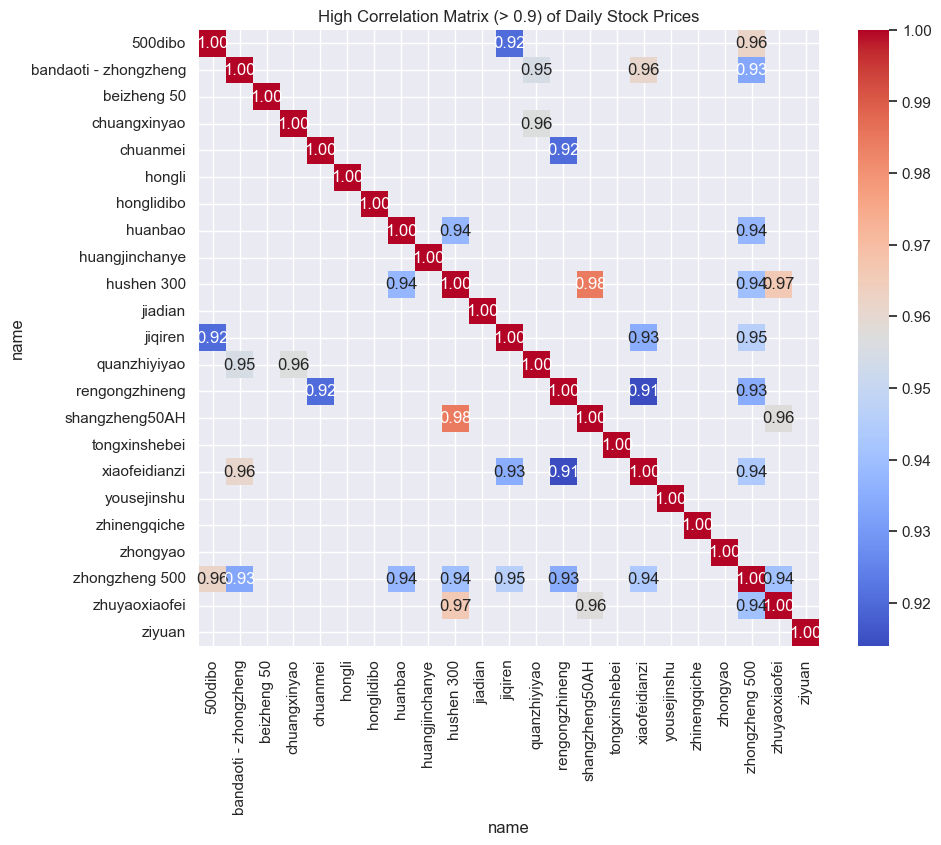

In [8]:
pivot_df = df_fund[df_fund['date']>='2023-04-01'][['date','NAV', 'name']].pivot(index='date', columns='name', values='NAV')
correlation_matrix = pivot_df.corr()

high_correlation = correlation_matrix[correlation_matrix >= 0.91]

plt.figure(figsize=(10, 8))
sns.heatmap(high_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('High Correlation Matrix (> 0.9) of Daily Stock Prices')
plt.show()

In [9]:
df_fund_sub = df_fund[df_fund['date']>='2024-02-05']
print(df_fund_sub.shape)
df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])
base_nav = df_fund_sub[df_fund_sub['date'] == '2024-02-05'][['name', 'NAV', 'NAV-Cum']]

# Rename the 'stock_price' column to 'base_price'
base_nav.columns = ['name', 'base_NAV', 'base_NAV-Cum']

# Merge base_prices with the original DataFrame to get base prices for all dates
df_fund_sub = pd.merge(df_fund_sub, base_nav, on='name', how='left')

# Calculate the relative price ratio
df_fund_sub['relative_price'] = df_fund_sub['NAV'] / df_fund_sub['base_NAV']
# df_fund_sub.loc[df_fund_sub['name'] == 'hongli', 'relative_price'] = df_fund_sub.loc[df_fund_sub['name'] == 'hongli', 'NAV-Cum'] / df_fund_sub.loc[df_fund_sub['name'] == 'hongli', 'base_NAV-Cum']

df_fund_sub.head()

(966, 6)


/var/folders/4r/jygz5t7n24724h42lgmbf1hw0000gn/T/ipykernel_95721/3251985981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])


date     NAV  NAV-Cum change    code            name  base_NAV  \
0 2024-04-12  1.2169   1.2169  -0.42  007029  zhongzheng 500    1.0424   
1 2024-04-11  1.2220   1.2220   0.49  007029  zhongzheng 500    1.0424   
2 2024-04-10  1.2161   1.2161  -1.19  007029  zhongzheng 500    1.0424   
3 2024-04-09  1.2308   1.2308   0.78  007029  zhongzheng 500    1.0424   
4 2024-04-08  1.2213   1.2213  -1.35  007029  zhongzheng 500    1.0424   

   base_NAV-Cum  relative_price  
0        1.0424        1.167402  
1        1.0424        1.172295  
2        1.0424        1.166635  
3        1.0424        1.180737  
4        1.0424        1.171623

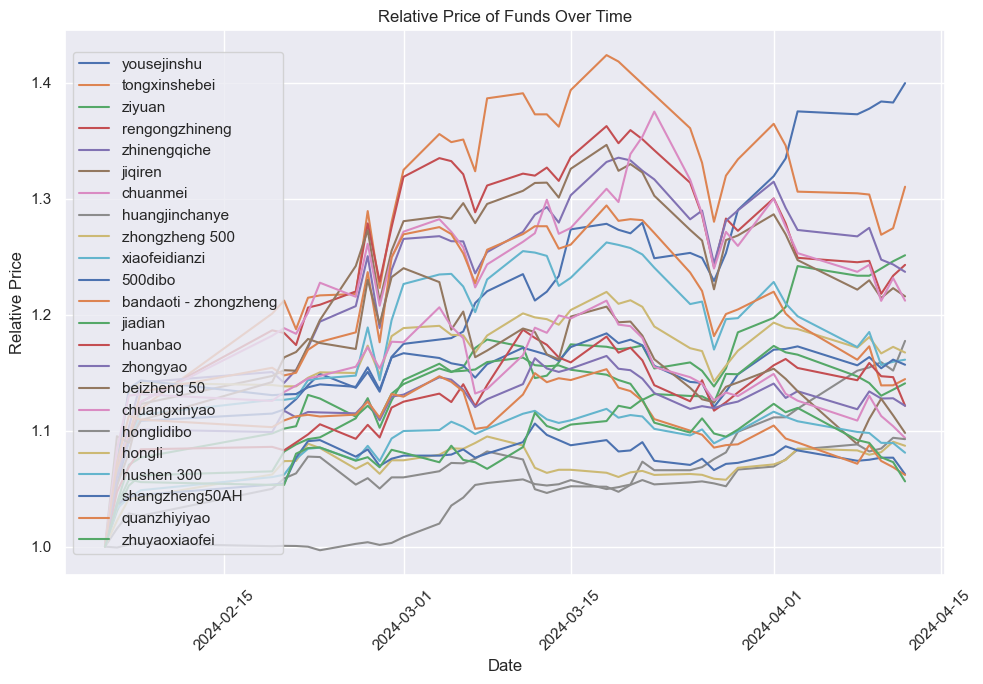

In [10]:
# Assuming df contains the relative_price column and date column is already in datetime format
# Get a list of unique stock names

last_date = df_fund_sub['date'].max()
# Filter the DataFrame to get data only for the last date
last_date_data = df_fund_sub[df_fund_sub['date'] == last_date]
# Sort the data by relative_price in descending order
sorted_data = last_date_data.sort_values(by='relative_price', ascending=False)

# Get the sorted list of stock names
sorted_stock_names = sorted_data['name'].tolist()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10,7))

# Iterate through each stock and plot its relative price over time
for name in sorted_stock_names:
    fund_data = df_fund_sub[df_fund_sub['name'] == name]
    ax.plot(fund_data['date'], fund_data['relative_price'], label=name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Relative Price')
ax.set_title('Relative Price of Funds Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend(loc='center left')

# Show plot
plt.tight_layout()
plt.show()

In [11]:
# Also check increase rate from 2024-02-05 to peak

sorted_data.merge(
    df_fund_sub.groupby('name')['relative_price'].max().reset_index().rename(columns={'relative_price':'peak_relative_price'}),
    on='name'
)

date       NAV   NAV-Cum change    code                   name  \
0  2024-04-12  0.786800  0.786800   1.21  013438            yousejinshu   
1  2024-04-12  1.110300  1.110300   2.81  007818          tongxinshebei   
2  2024-04-12  1.205000  1.205000   0.42  012808                 ziyuan   
3  2024-04-12  0.849289  0.849289    0.8  008021         rengongzhineng   
4  2024-04-12  0.740100  0.740100  -0.51  010956           zhinengqiche   
5  2024-04-12  0.859000  0.859000  -0.58  018094                jiqiren   
6  2024-04-12  0.721100  0.721100  -1.58  004753               chuanmei   
7  2024-04-12  1.918500  1.918500   2.22  000307         huangjinchanye   
8  2024-04-12  1.216900  1.216900  -0.42  007029         zhongzheng 500   
9  2024-04-12  0.928399  0.928399   0.15  014907          xiaofeidianzi   
10 2024-04-12  1.324222  1.324222  -0.38  003318                500dibo   
11 2024-04-12  1.353900  1.353900   0.47  007301  bandaoti - zhongzheng   
12 2024-04-12  1.194800  1.194800   0.48  005064                jiadian   
13 2024-04-12  0.679100  0.679100  -2.15  002984                huanbao   
14 2024-04-12  0.870439  0.870439  -0.58  501012               zhongyao   
15 2024-04-12  0.877900  0.877900  -1.36  017513            beizheng 50   
16 2024-04-12  0.784744  0.784744  -0.95  012737           chuangxinyao   
17 2024-04-12  1.895200  1.895200  -0.11  005562             honglidibo   
18 2024-04-12  1.223300  1.366300  -0.32  009052                 hongli   
19 2024-04-12  1.335600  1.335600  -0.77  007339             hushen 300   
20 2024-04-12  1.191000  1.191000  -1.33  501050         shangzheng50AH   
21 2024-04-12  0.747200  0.747200  -0.63  002978           quanzhiyiyao   
22 2024-04-12  1.043600  1.043600  -1.55  009180          zhuyaoxiaofei   

    base_NAV  base_NAV-Cum  relative_price  peak_relative_price  
0   0.562100      0.562100        1.399751             1.399751  
1   0.847300      0.847300        1.310398             1.423935  
2   0.963000      0.963000        1.251298             1.251298  
3   0.683251      0.683251        1.243012             1.362694  
4   0.598300      0.598300        1.237005             1.335450  
5   0.706500      0.706500        1.215853             1.346497  
6   0.594900      0.594900        1.212136             1.375189  
7   1.629400      1.629400        1.177427             1.177427  
8   1.042400      1.042400        1.167402             1.219685  
9   0.799498      0.799498        1.161228             1.262352  
10  1.144639      1.144639        1.156891             1.183932  
11  1.183000      1.183000        1.144463             1.294252  
12  1.047300      1.047300        1.140838             1.173112  
13  0.605500      0.605500        1.121552             1.187118  
14  0.776175      0.776175        1.121447             1.164455  
15  0.799500      0.799500        1.098061             1.240150  
16  0.717481      0.717481        1.093749             1.212146  
17  1.734400      1.734400        1.092712             1.093865  
18  1.125400      1.268400        1.086991             1.094988  
19  1.235500      1.235500        1.081020             1.118818  
20  1.121000      1.121000        1.062444             1.106155  
21  0.703700      0.703700        1.061816             1.153048  
22  0.988000      0.988000        1.056275             1.127024

/var/folders/4r/jygz5t7n24724h42lgmbf1hw0000gn/T/ipykernel_95721/1979582722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])


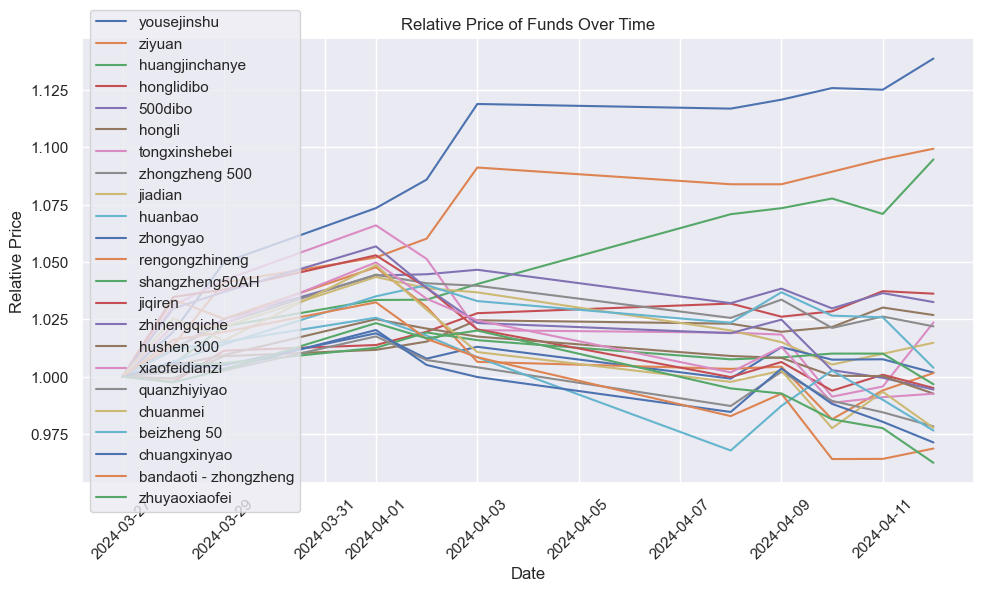

In [12]:
df_fund_sub = df_fund[df_fund['date']>='2024-03-27']
df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])
base_nav = df_fund_sub[df_fund_sub['date'] == '2024-03-27'][['name', 'NAV']]

# Rename the 'stock_price' column to 'base_price'
base_nav.columns = ['name', 'base_NAV']

# Merge base_prices with the original DataFrame to get base prices for all dates
df_fund_sub = pd.merge(df_fund_sub, base_nav, on='name', how='left')

# Calculate the relative price ratio
df_fund_sub['relative_price'] = df_fund_sub['NAV'] / df_fund_sub['base_NAV']

# Assuming df contains the relative_price column and date column is already in datetime format
# Get a list of unique stock names

last_date = df_fund_sub['date'].max()
# Filter the DataFrame to get data only for the last date
last_date_data = df_fund_sub[df_fund_sub['date'] == last_date]
# Sort the data by relative_price in descending order
sorted_data = last_date_data.sort_values(by='relative_price', ascending=False)

# Get the sorted list of stock names
sorted_stock_names = sorted_data['name'].tolist()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through each stock and plot its relative price over time
for name in sorted_stock_names:
    fund_data = df_fund_sub[df_fund_sub['name'] == name]
    ax.plot(fund_data['date'], fund_data['relative_price'], label=name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Relative Price')
ax.set_title('Relative Price of Funds Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend(loc='center left')

# Show plot
plt.tight_layout()
plt.show()

In [13]:
from kneed import KneeLocator
from sklearn.cluster import KMeans

def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

def identify_weak_support_resistance(data):
    # Initialize an empty list to store the labels (support, resistance, neither)
    labels = []

    # Iterate through the dataframe to identify weak support and weak resistance
    for i in range(len(data)):
        if i == 0 or i == len(data) - 1:
            # Edge cases where there's no previous or following day
            labels.append("neither")
        elif data['NAV'][i] < data['NAV'][i - 1] and data['NAV'][i] < data['NAV'][i + 1]:
            # Weak support condition
            labels.append("weak support")
        elif data['NAV'][i] > data['NAV'][i - 1] and data['NAV'][i] > data['NAV'][i + 1]:
            # Weak resistance condition
            labels.append("weak resistance")
        else:
            # Neither weak support nor weak resistance
            labels.append("neither")

    # Add the labels to a new column in the dataframe
    data['Support/Resistance'] = labels

    return data

In [14]:
from dateutil.relativedelta import relativedelta
from math import ceil, floor

def stock_bollinger_move(stock_df, start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d')):
    df = stock_df[stock_df['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
    df = df.sort_values(by='date').reset_index()

    if df['name'].unique()[0] == 'hongli':
        df['daily_price'] = df['NAV-Cum']
    else:
        df['daily_price'] = df['NAV']

    
    print(datetime.today().strftime('%Y-%m-%d'))
    print('* previous stock price closing', round(df.iloc[-1]['daily_price'],2))

    # Support and Resistance
    df = identify_weak_support_resistance(df)
    low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"daily_price"]].set_index('date'))
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)
    
    high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"daily_price"]].set_index('date'))
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    
    print(low_centers)
    print(high_centers)

    df['20 Day MA'] = df['daily_price'].rolling(window=20).mean()
    df['20 Day STD'] = df['daily_price'].rolling(window=20).std()
    
    # Calculate upper and lower bands
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
    print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])
    fig, ax = plt.subplots(figsize=(32,8))
    ax.grid(True, alpha=0.5)
    ax.set_title(stock_df['name'].unique()[0])
    ax.plot(df['date'], df['daily_price'], label='Daily Price')
    ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
    ax.plot(df['date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
    ax.plot(df['date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
    ax.fill_between(df['date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands
    for low in low_centers[:]:
        ax.axhline(low[0], color='green', ls='--')
    
    for high in high_centers[:]:
        ax.axhline(high[0], color='red', ls='--')

zhongzheng 500
2024-04-12
* previous stock price closing 1.22
[[1.19573889]
 [1.29901579]
 [1.3723541 ]
 [1.43876667]
 [1.55024483]]
[[1.22608824]
 [1.31459722]
 [1.38827656]
 [1.45611892]
 [1.56567   ]]
Latest 20 Day MA: 1.2336449999999999
Latest Lower Bollinger Band: 1.1911925262638652
Latest Higher Bollinger Band: 1.2760974737361346


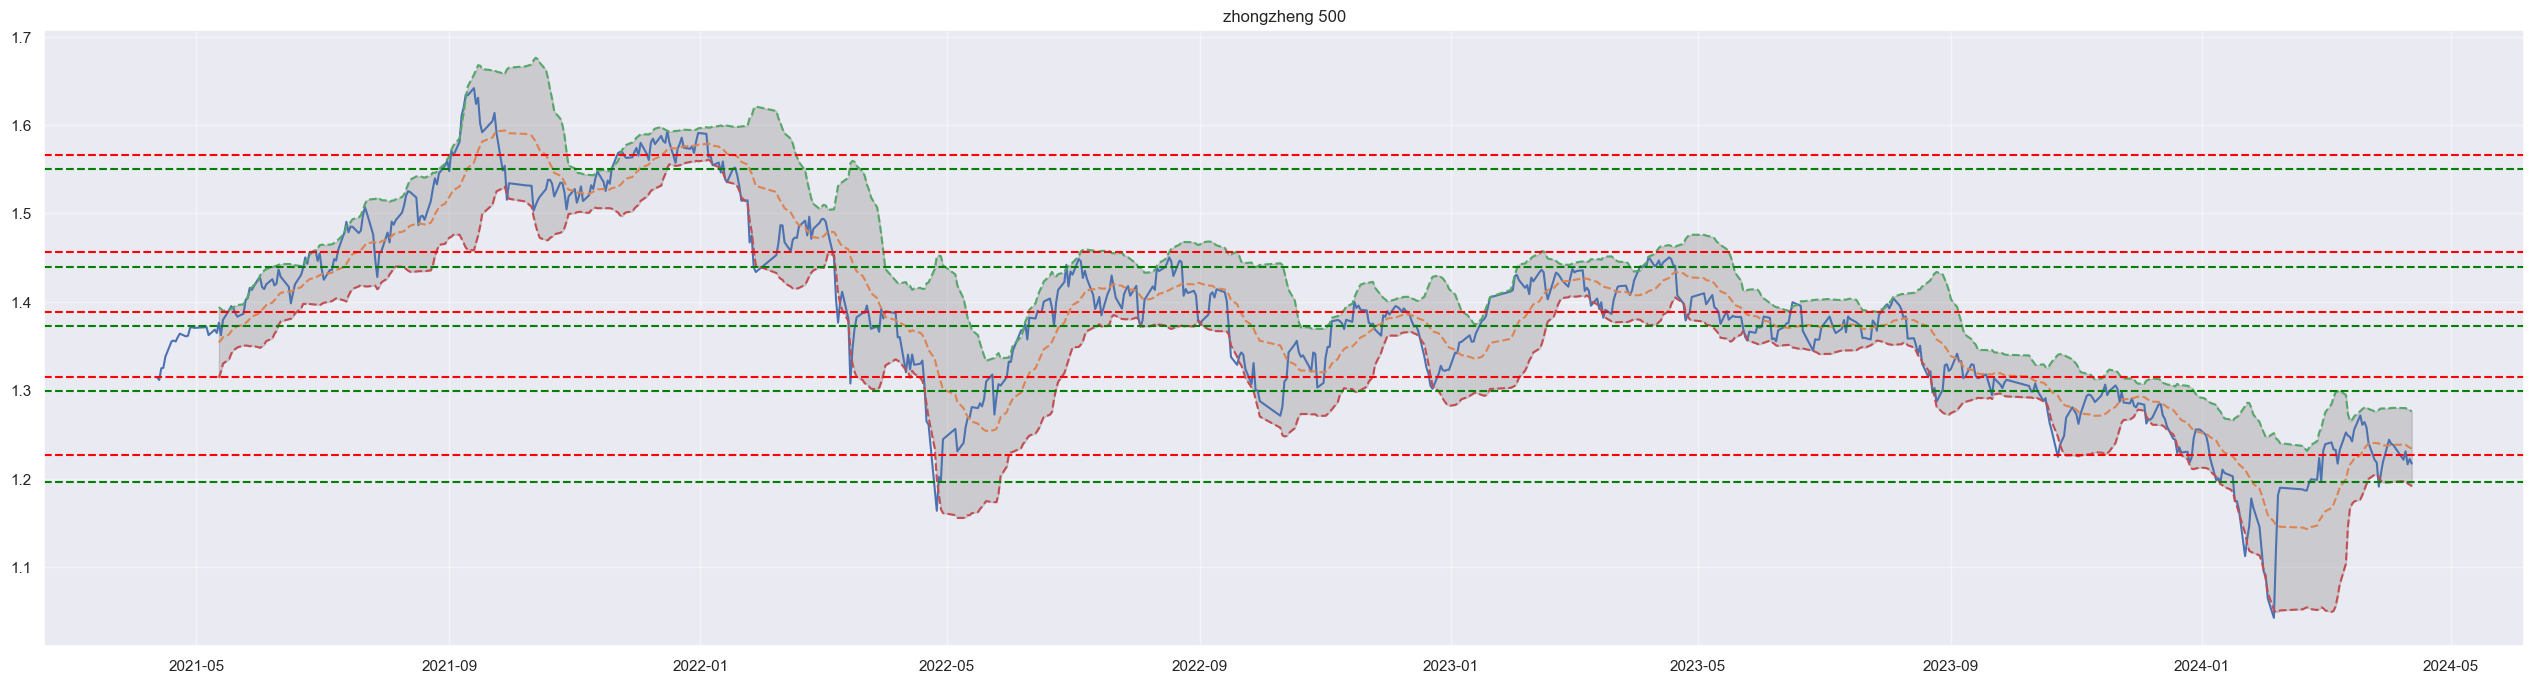

In [15]:
# solid buy 1.19
# sell at 1.24
print(df_fund["name"].unique().tolist()[0])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[0]])

500dibo
2024-04-12
* previous stock price closing 1.32
[[1.21723503]
 [1.29213311]
 [1.36986097]
 [1.42124643]]
[[1.2908509 ]
 [1.36725185]
 [1.42799992]]
Latest 20 Day MA: 1.3272370782753016
Latest Lower Bollinger Band: 1.290044312805209
Latest Higher Bollinger Band: 1.364429843745394


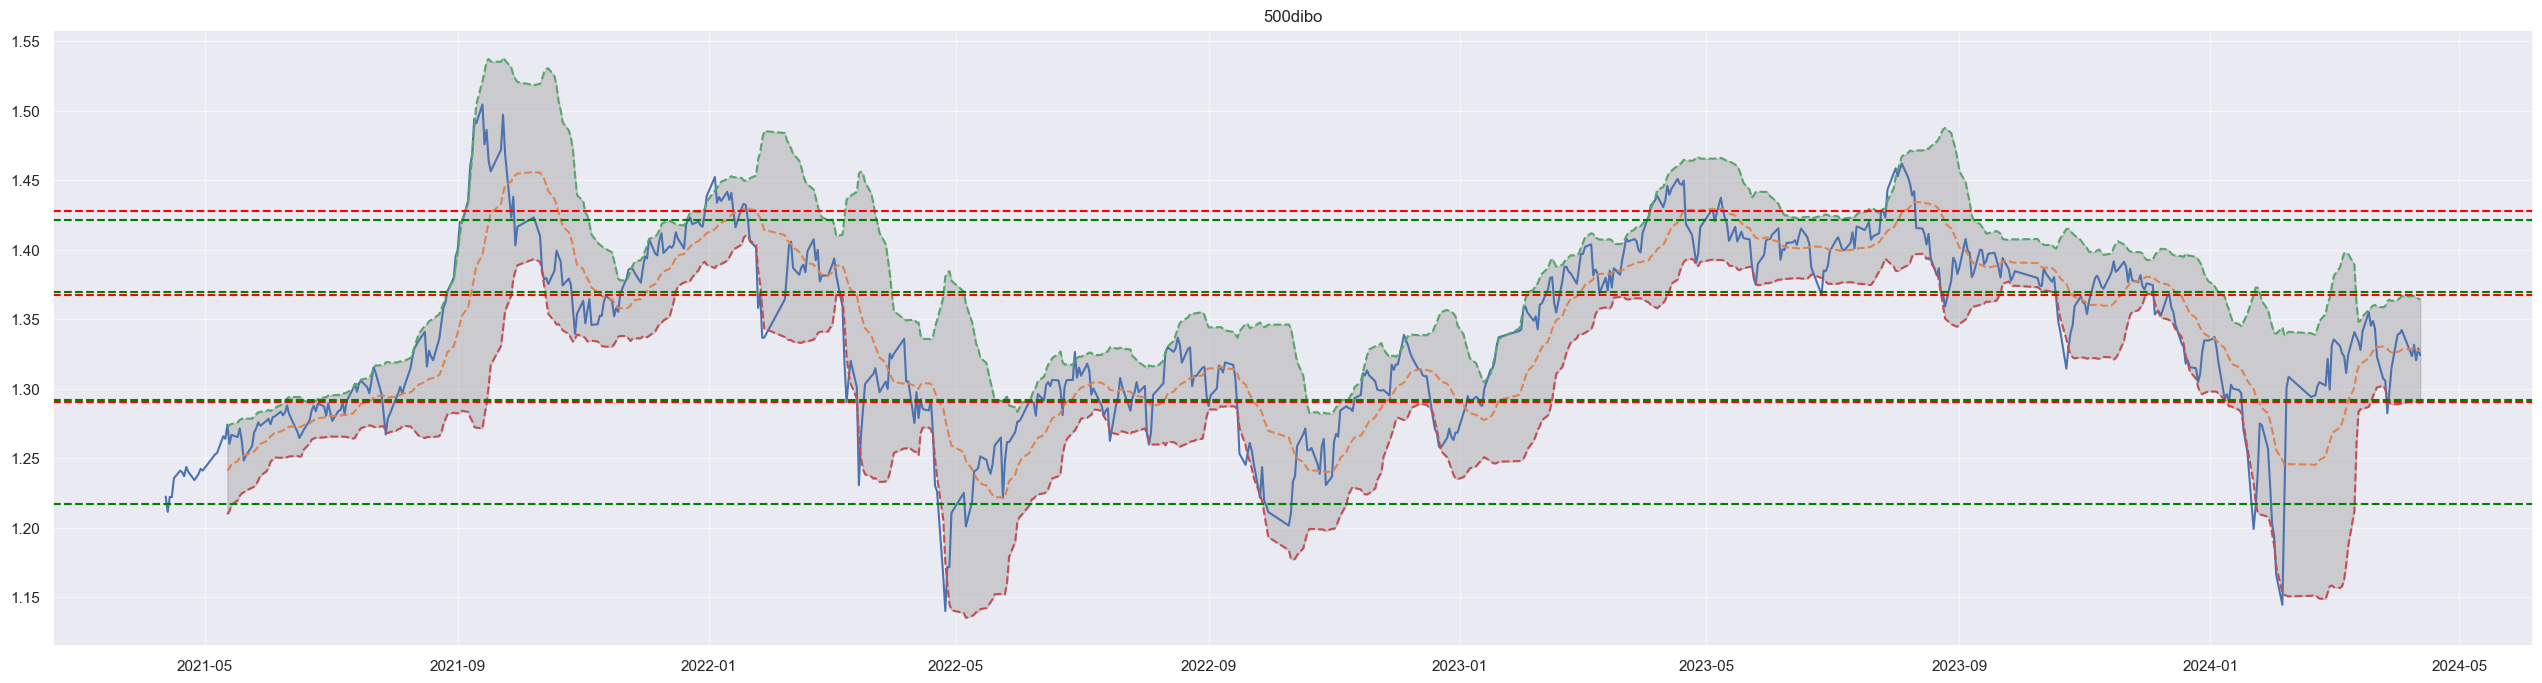

In [16]:
# solid buy at Lower Bollinger Band: 1.29
# sell at Higher Bollinger Band: 1.365
print(df_fund["name"].unique().tolist()[1])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[1]])

bandaoti - zhongzheng
2024-04-12
* previous stock price closing 1.35
[[1.36780769]
 [1.58452727]
 [1.70107778]
 [1.81113889]
 [1.89703529]
 [2.04141429]
 [2.18040714]
 [2.36061818]
 [2.4761875 ]
 [2.61678   ]]
[[1.43115385]
 [1.6573871 ]
 [1.7619963 ]
 [1.85685263]
 [1.97601875]
 [2.13747778]
 [2.28287778]
 [2.46736842]
 [2.63062857]
 [2.82623333]]
Latest 20 Day MA: 1.4397
Latest Lower Bollinger Band: 1.3179555394105813
Latest Higher Bollinger Band: 1.5614444605894187


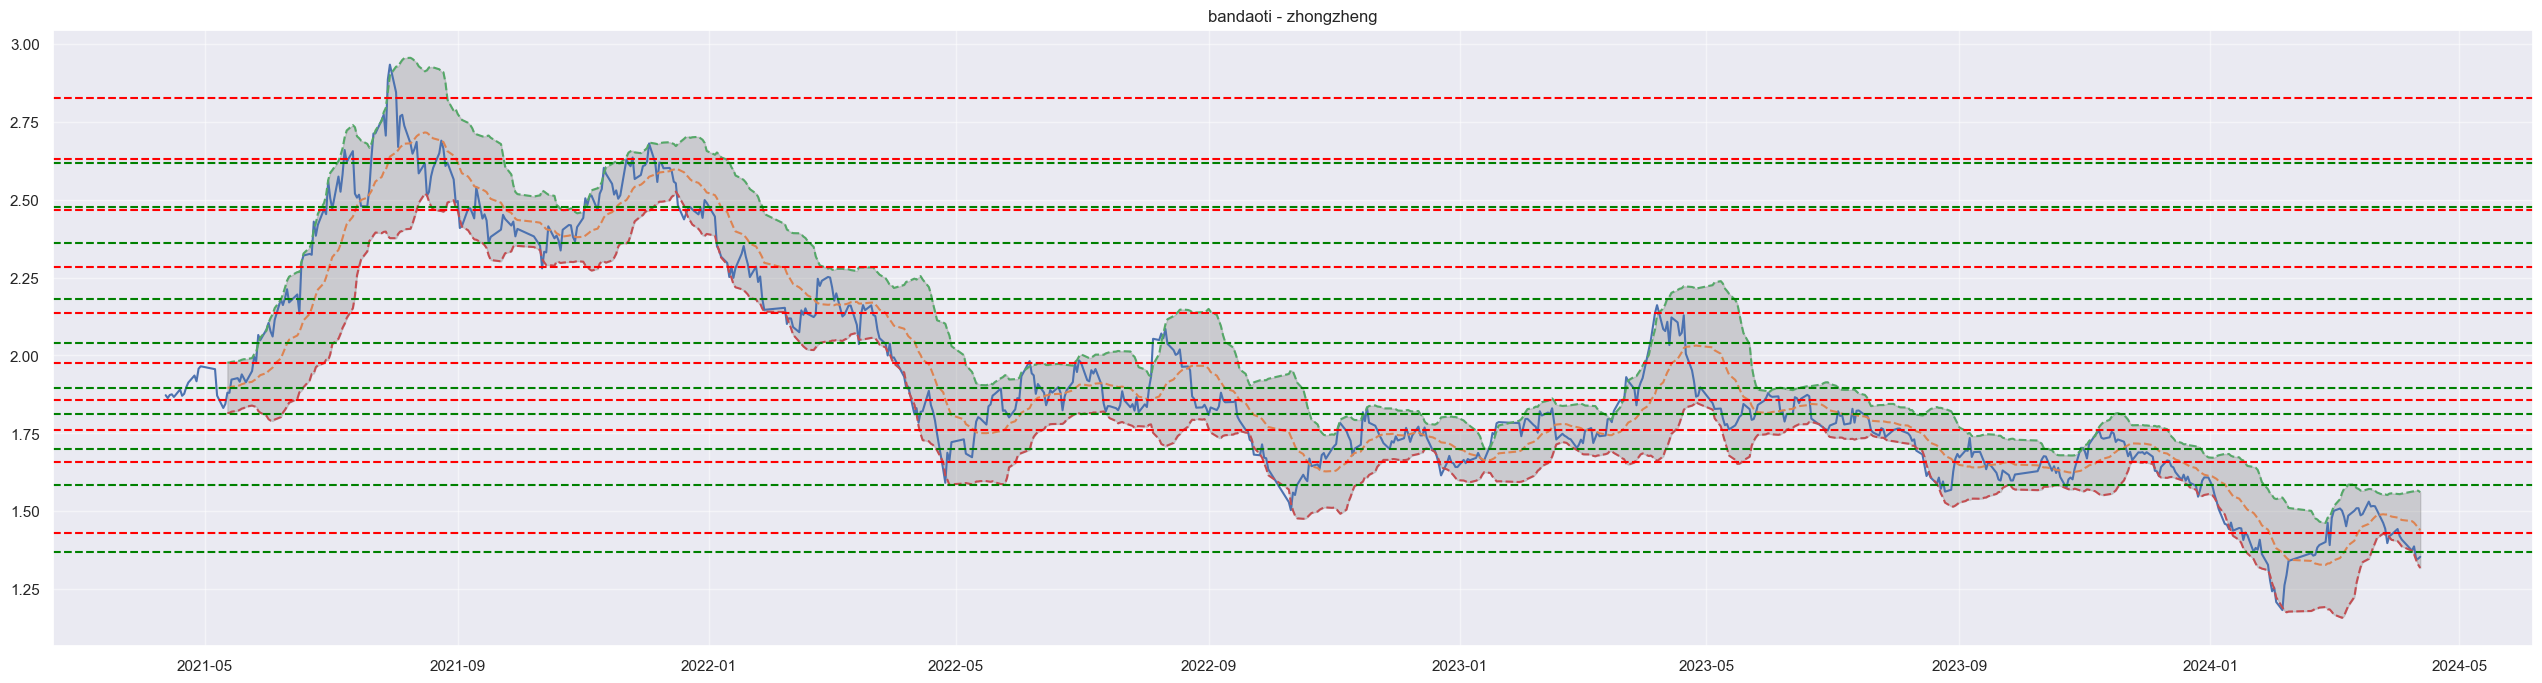

In [17]:
# down 0.07, up 0.25/0.3, multiplier 1.05
# try 1.3 buy
print(df_fund["name"].unique().tolist()[2])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[2]])

zhinengqiche
2024-04-12
* previous stock price closing 0.74
[[0.71887391]
 [0.79984545]
 [0.86998868]
 [0.95916333]
 [1.06809375]]
[[0.78189091]
 [0.87173286]
 [0.97442   ]
 [1.08904706]]
Latest 20 Day MA: 0.7706500000000001
Latest Lower Bollinger Band: 0.7333767557510438
Latest Higher Bollinger Band: 0.8079232442489563


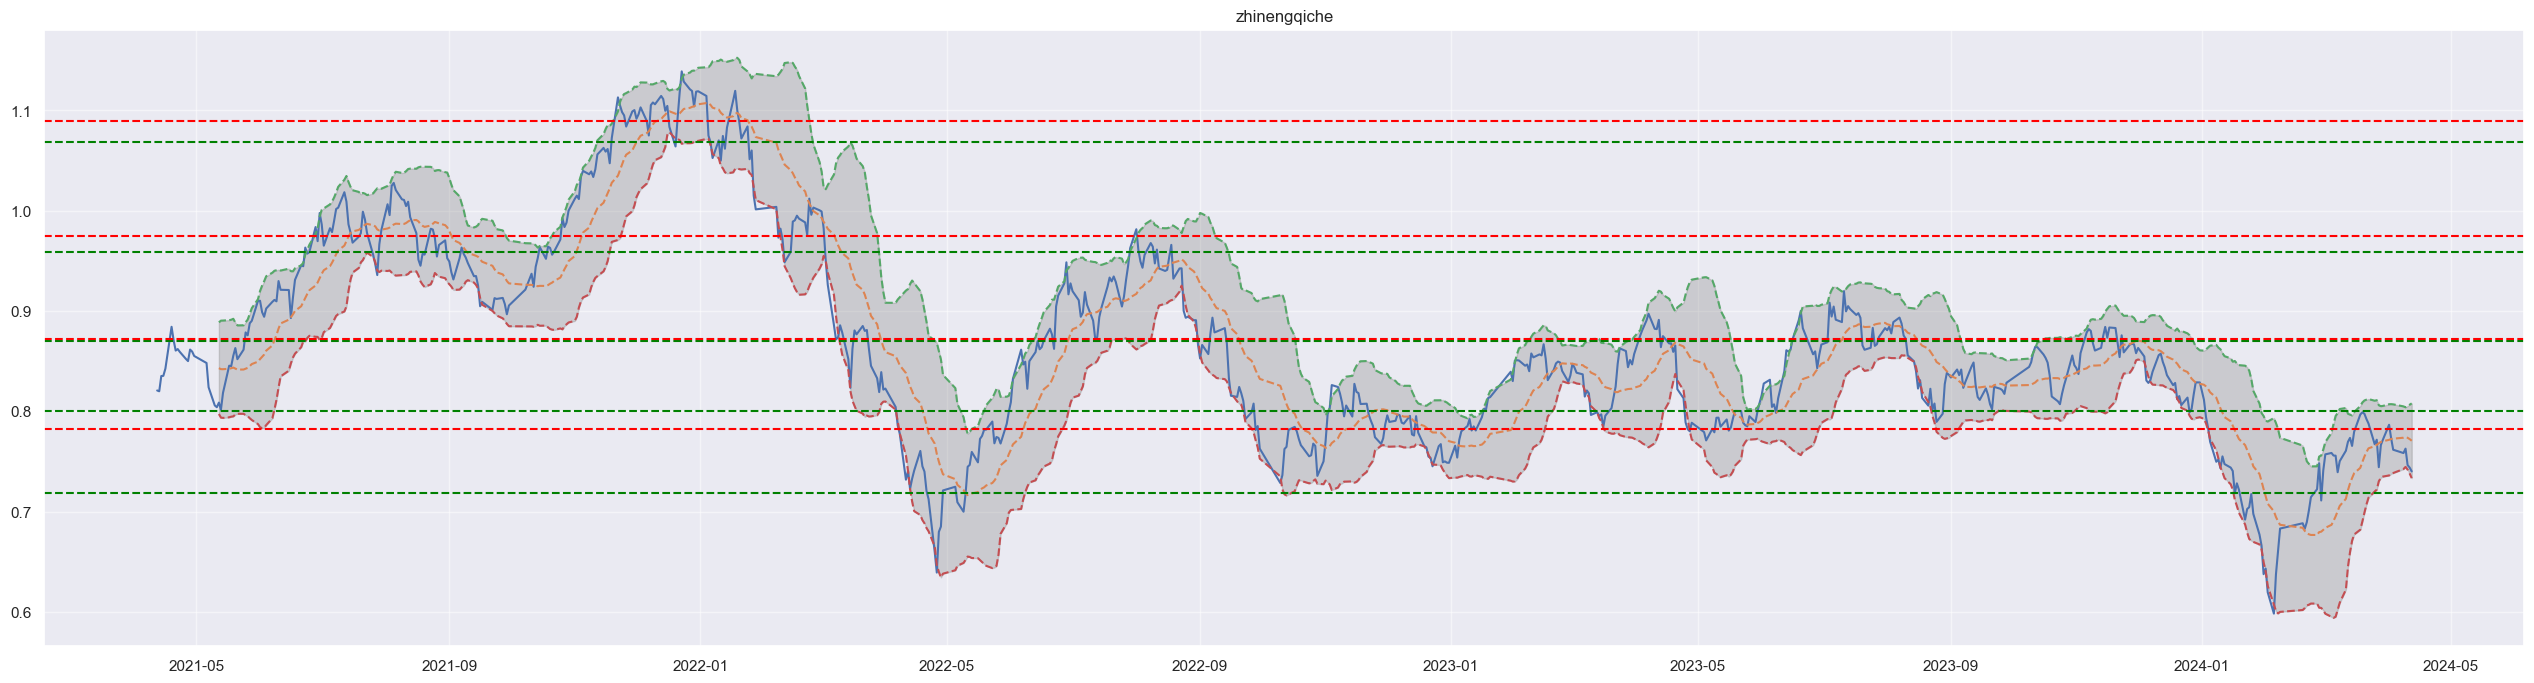

In [18]:
# sell 0.8
# try buy 0.74
print(df_fund["name"].unique().tolist()[3])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[3]])

huanbao
2024-04-12
* previous stock price closing 0.68
[[0.67474348]
 [0.75095   ]
 [0.89204   ]
 [1.01795937]
 [1.12090357]
 [1.2303    ]
 [1.32263077]]
[[0.71451579]
 [0.89759474]
 [1.03629487]
 [1.16006154]
 [1.26206552]
 [1.34730714]]
Latest 20 Day MA: 0.6955549999999999
Latest Lower Bollinger Band: 0.6740484306242996
Latest Higher Bollinger Band: 0.7170615693757002


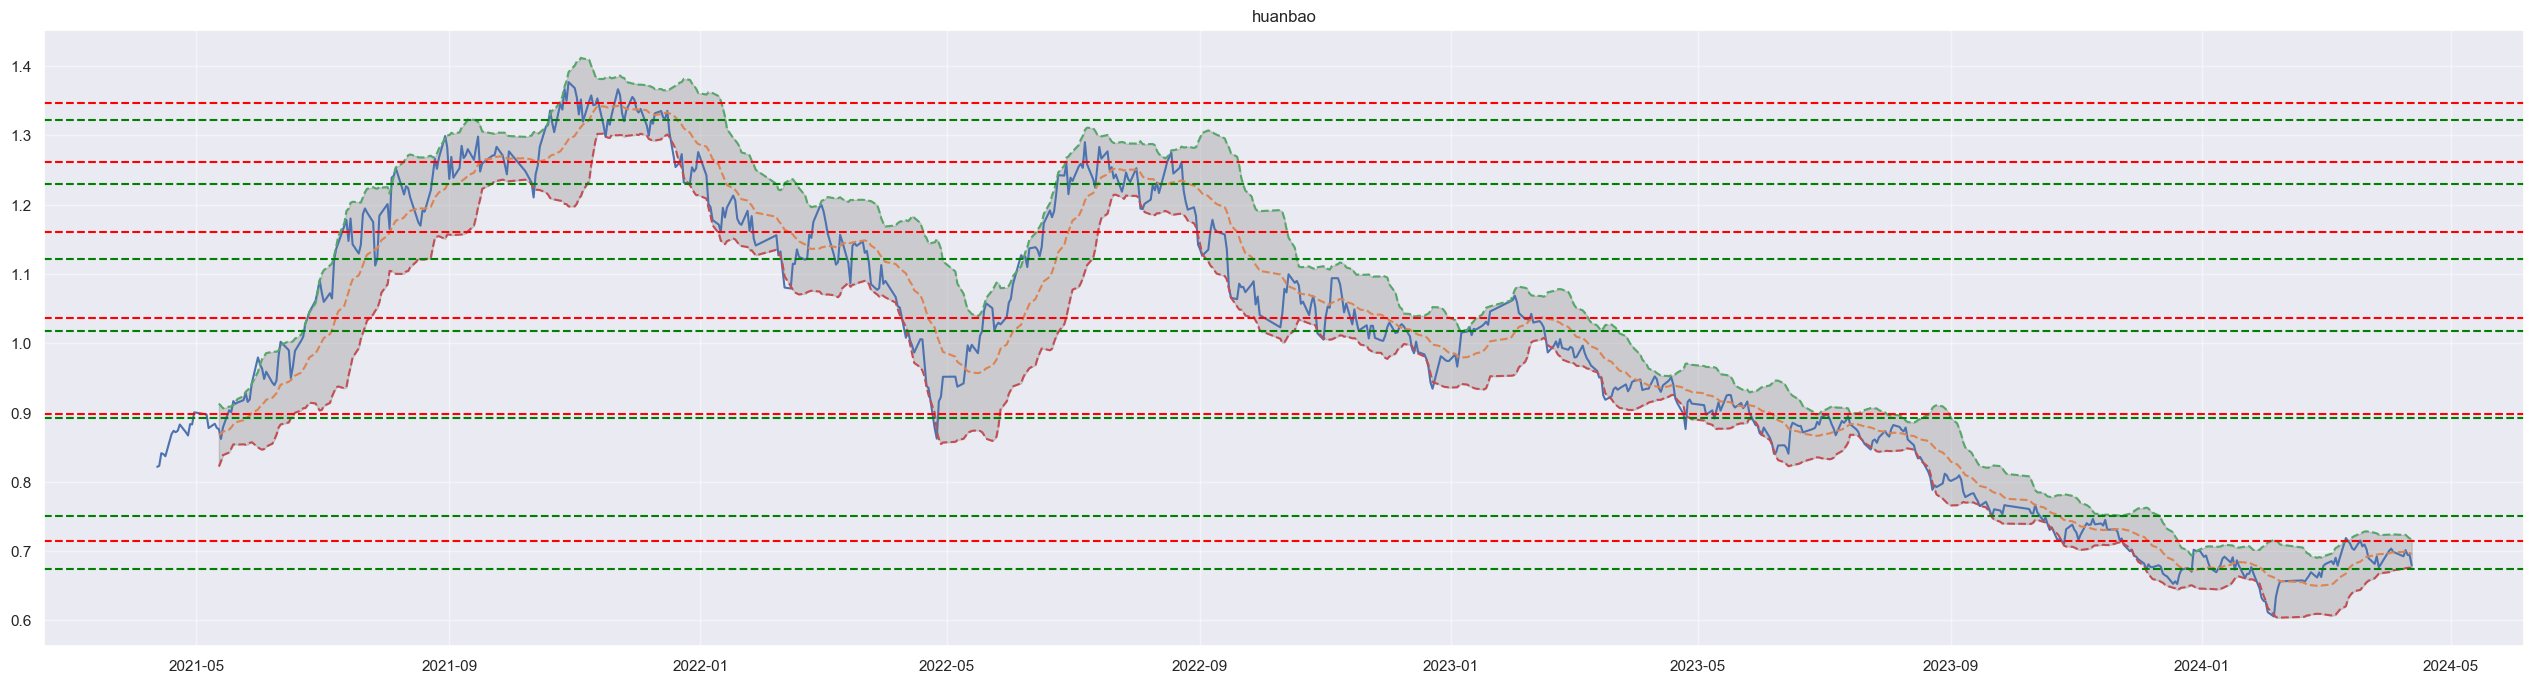

In [19]:
# solid buy at 0.67; sell between 0.715 - 0.72
print(df_fund["name"].unique().tolist()[4])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[4]])

jiqiren
2024-04-12
* previous stock price closing 0.86
[[0.81836364]
 [0.94716429]
 [1.04715   ]]
[[0.86871333]
 [0.97950833]
 [1.06833636]]
Latest 20 Day MA: 0.8991049999999999
Latest Lower Bollinger Band: 0.8379878743098037
Latest Higher Bollinger Band: 0.9602221256901962


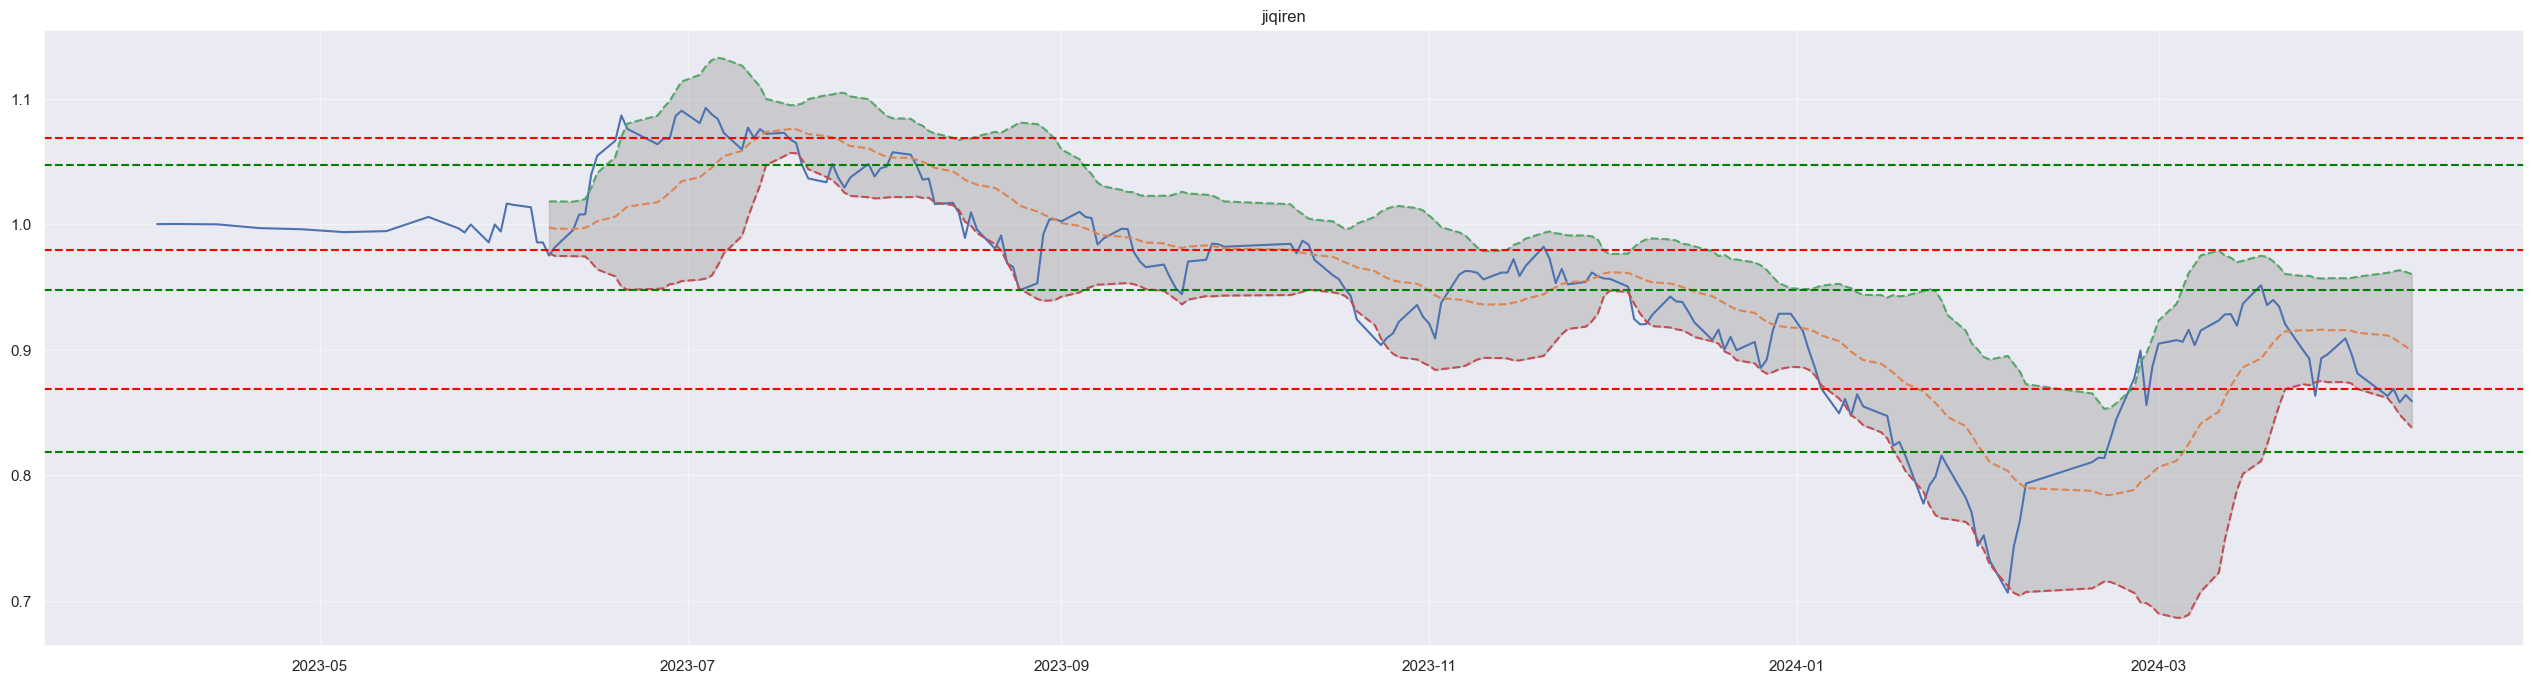

In [20]:
# bought 0.86
print(df_fund["name"].unique().tolist()[5])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[5]])

xiaofeidianzi
2024-04-12
* previous stock price closing 0.93
[[0.91554539]
 [1.02364614]
 [1.11082901]
 [1.22316762]]
[[0.94158191]
 [1.04256015]
 [1.12701456]
 [1.23659653]]
Latest 20 Day MA: 0.9667697558550005
Latest Lower Bollinger Band: 0.9109229003201691
Latest Higher Bollinger Band: 1.0226166113898318


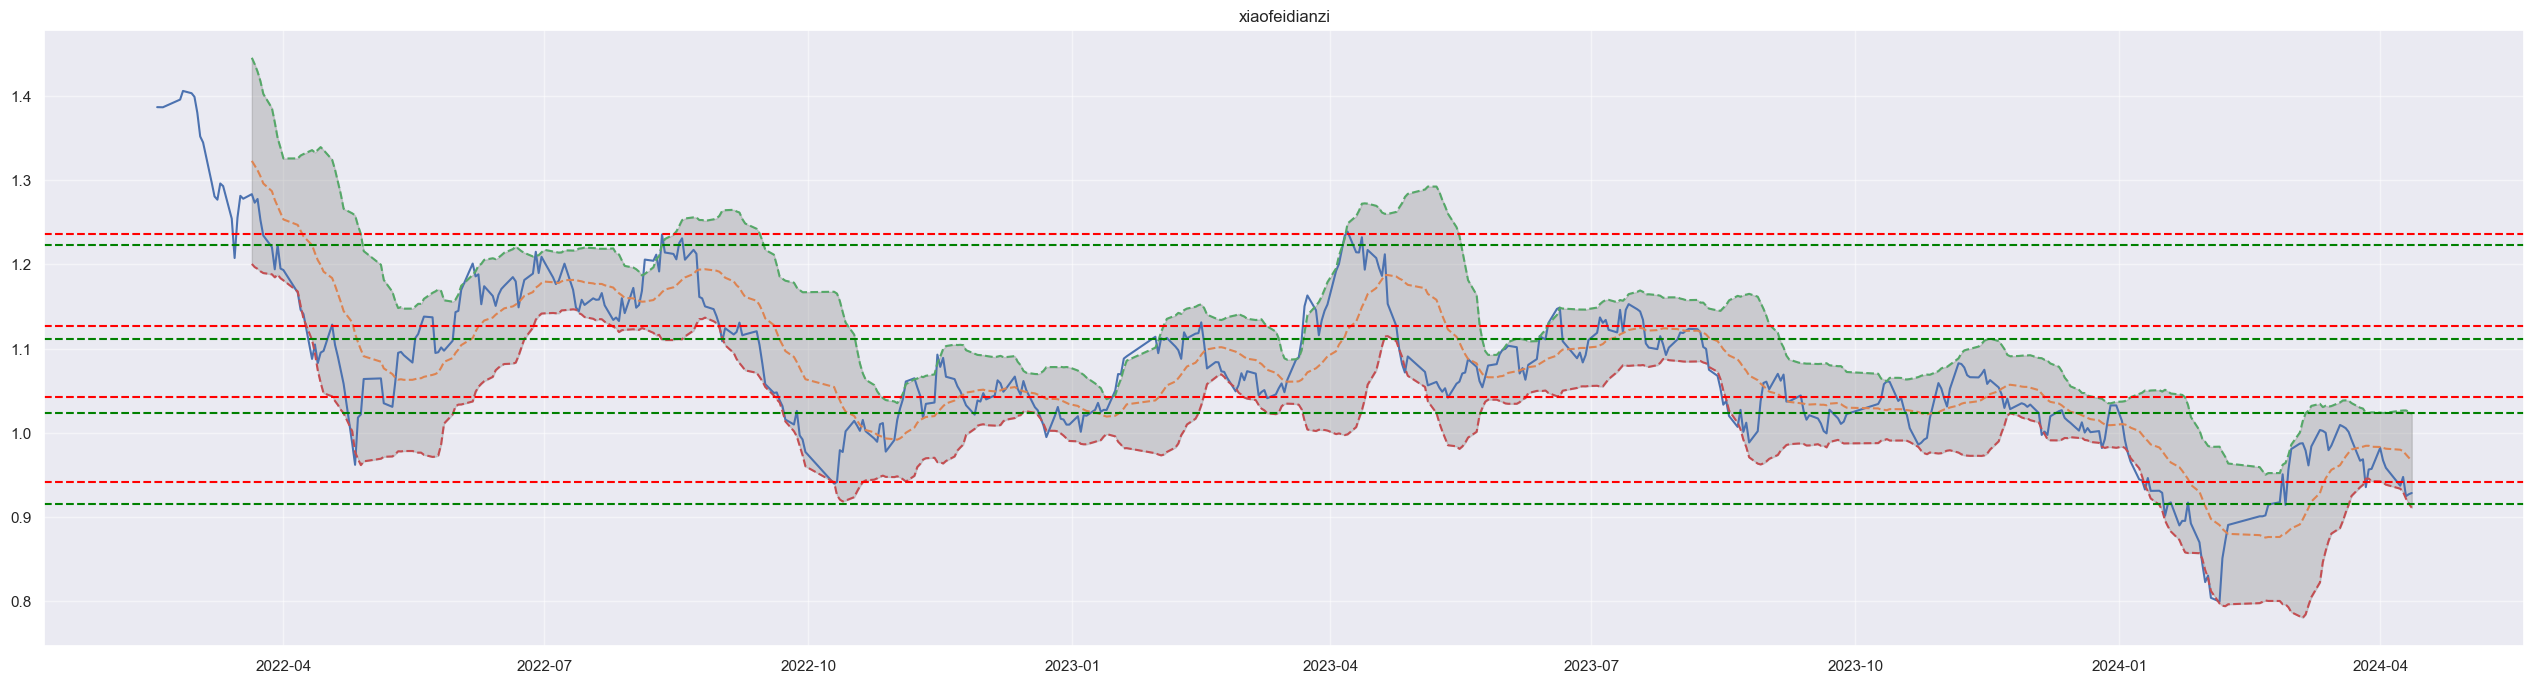

In [21]:
# bought at Lower Bollinger Band: 0.930
# try sell at 20 Day MA: 0.9781

print(df_fund["name"].unique().tolist()[6])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[6]])

rengongzhineng
2024-04-12
* previous stock price closing 0.85
[[0.7753627 ]
 [0.86334412]
 [0.94142714]
 [1.04048822]
 [1.14048269]
 [1.22219632]]
[[0.82956688]
 [0.90970188]
 [0.99798728]
 [1.13662801]
 [1.2346605 ]]
Latest 20 Day MA: 0.8822595145087231
Latest Lower Bollinger Band: 0.8177639160275281
Latest Higher Bollinger Band: 0.9467551129899181


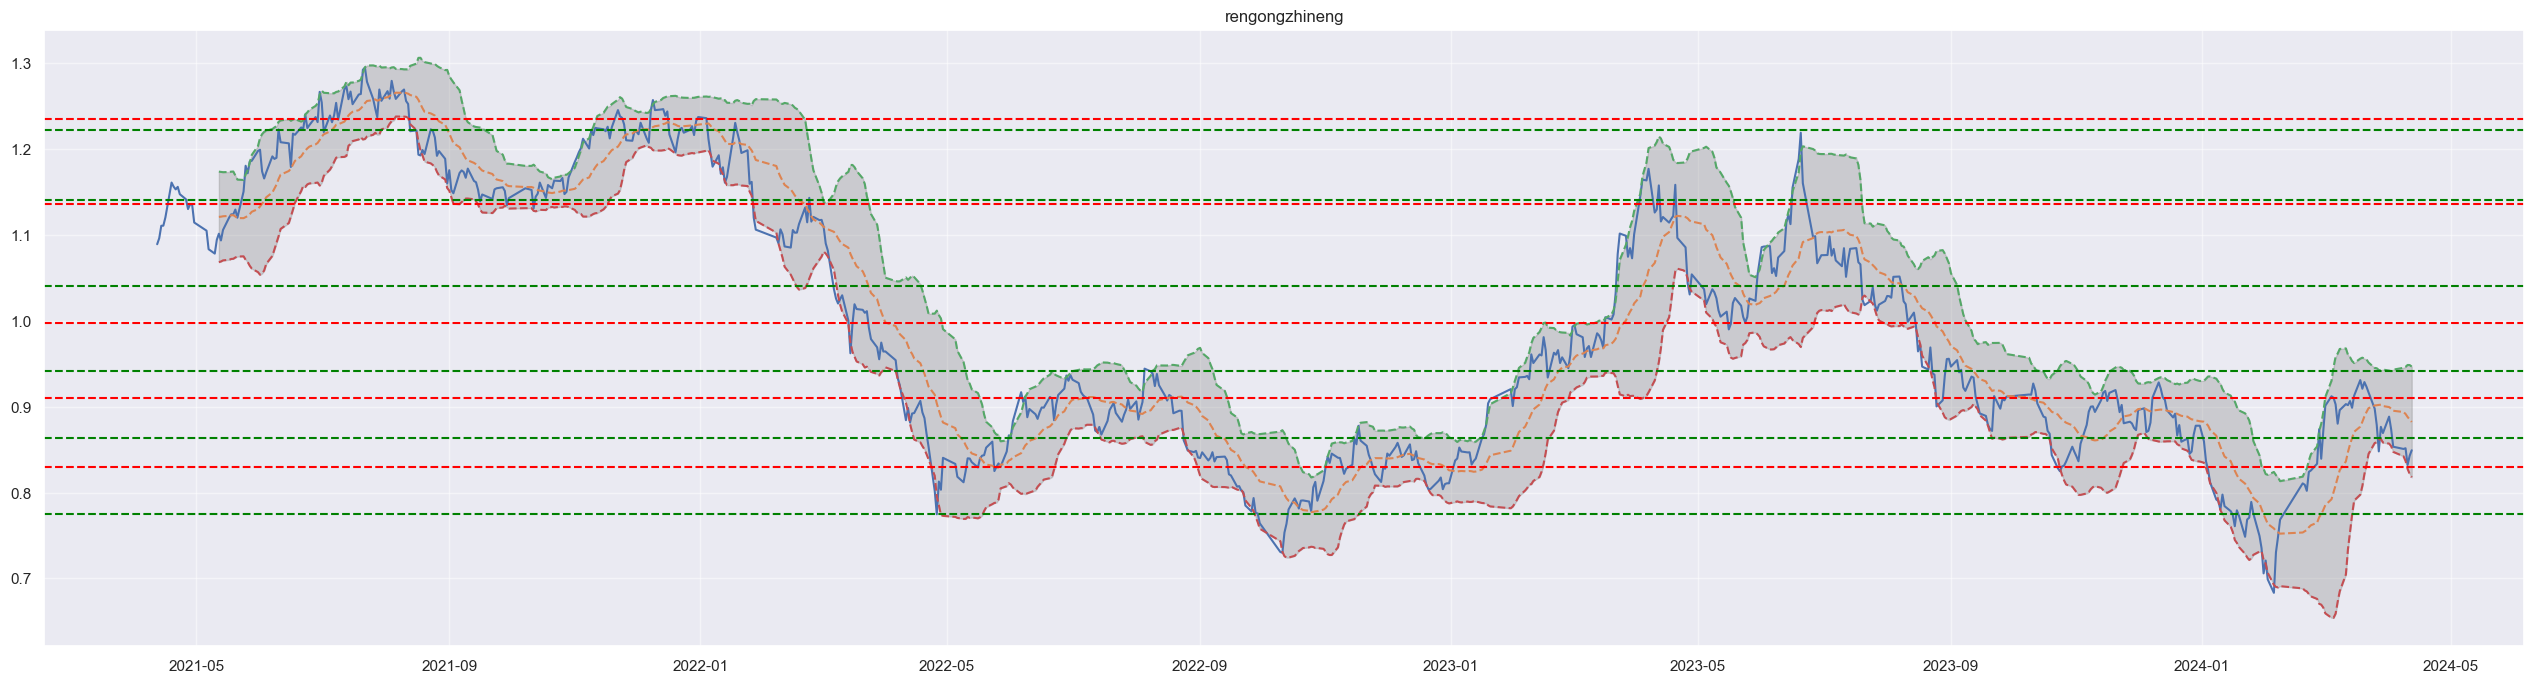

In [22]:
# bought at Lower Bollinger Band: 0.85
# try sell at 20 Day MA: 0.892

print(df_fund["name"].unique().tolist()[7])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[7]])

hushen 300
2024-04-12
* previous stock price closing 1.34
[[1.26739167]
 [1.36871111]
 [1.45030465]
 [1.5316    ]
 [1.64495556]
 [1.75378919]
 [1.82683684]]
[[1.28116   ]
 [1.38481111]
 [1.4692619 ]
 [1.5502    ]
 [1.67347   ]
 [1.7758697 ]
 [1.84596667]]
Latest 20 Day MA: 1.3618999999999999
Latest Lower Bollinger Band: 1.3361338451289582
Latest Higher Bollinger Band: 1.3876661548710416


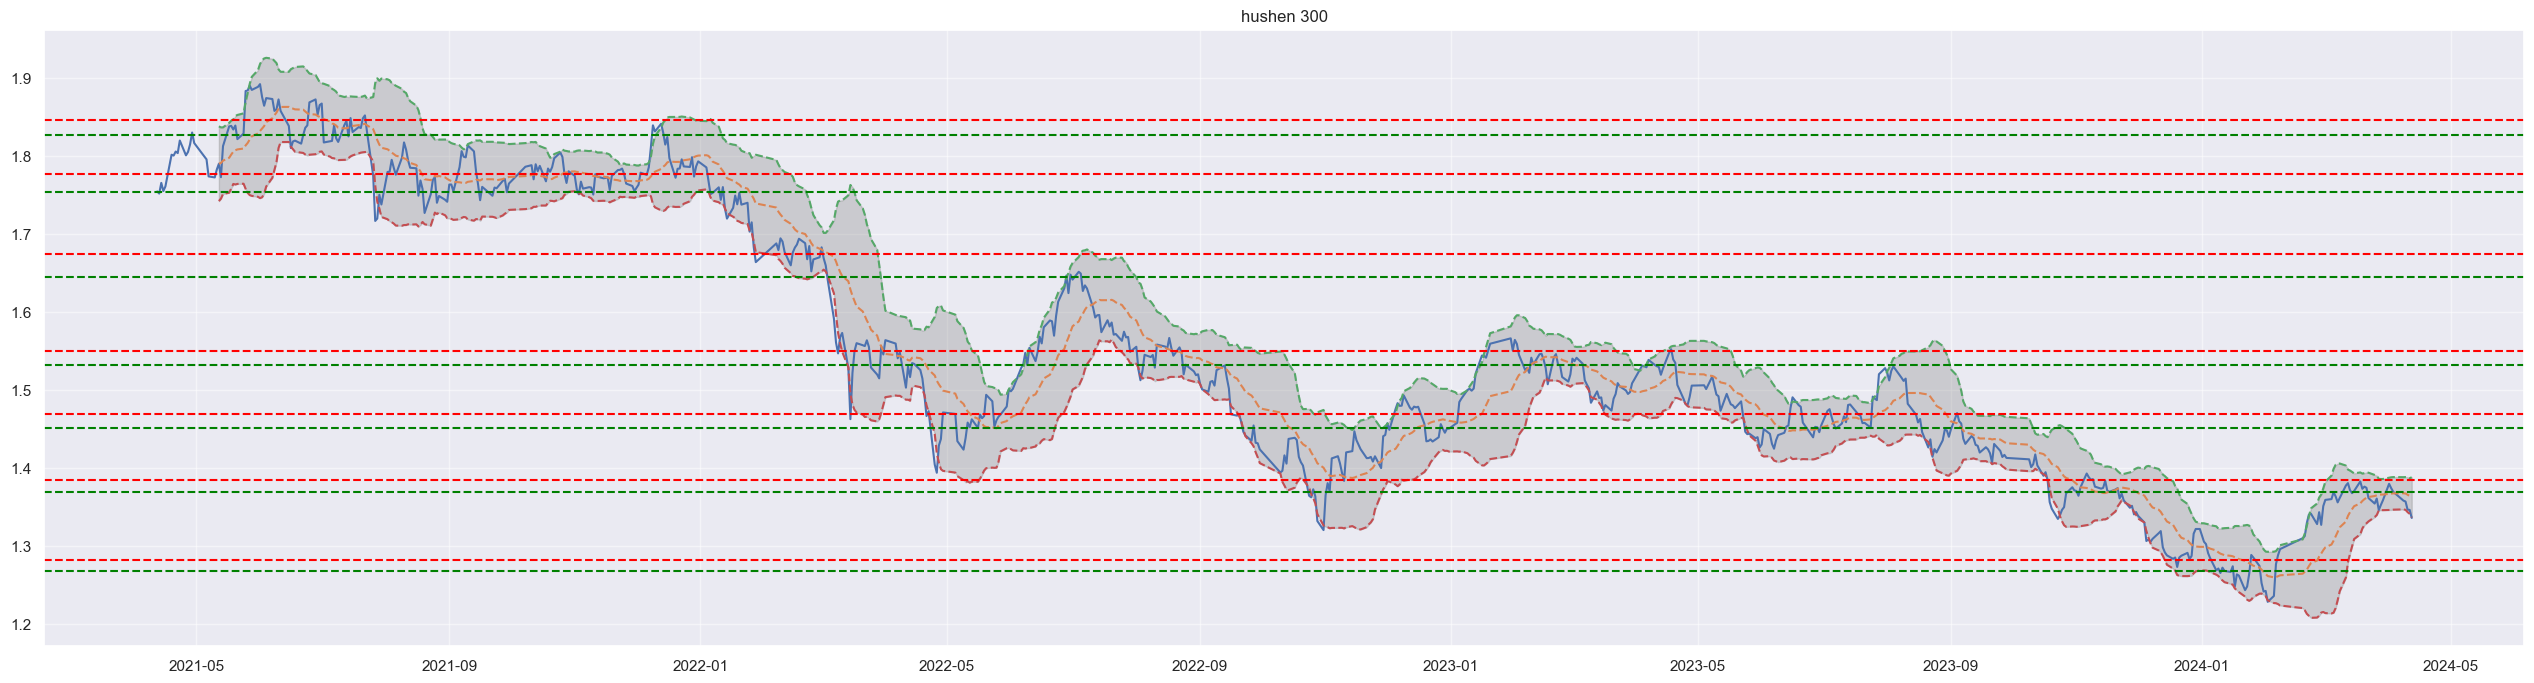

In [23]:
# 1.385 sell
# buy at lower bollinger band at 1.343

print(df_fund["name"].unique().tolist()[8])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[8]])

zhuyaoxiaofei
2024-04-12
* previous stock price closing 1.04
[[1.04047619]
 [1.1470375 ]
 [1.23784783]
 [1.31485312]
 [1.41141   ]
 [1.52016667]]
[[1.04712   ]
 [1.15328824]
 [1.25683333]
 [1.3382875 ]
 [1.42443103]
 [1.53271579]]
Latest 20 Day MA: 1.0886600000000002
Latest Lower Bollinger Band: 1.052640391305236
Latest Higher Bollinger Band: 1.1246796086947644


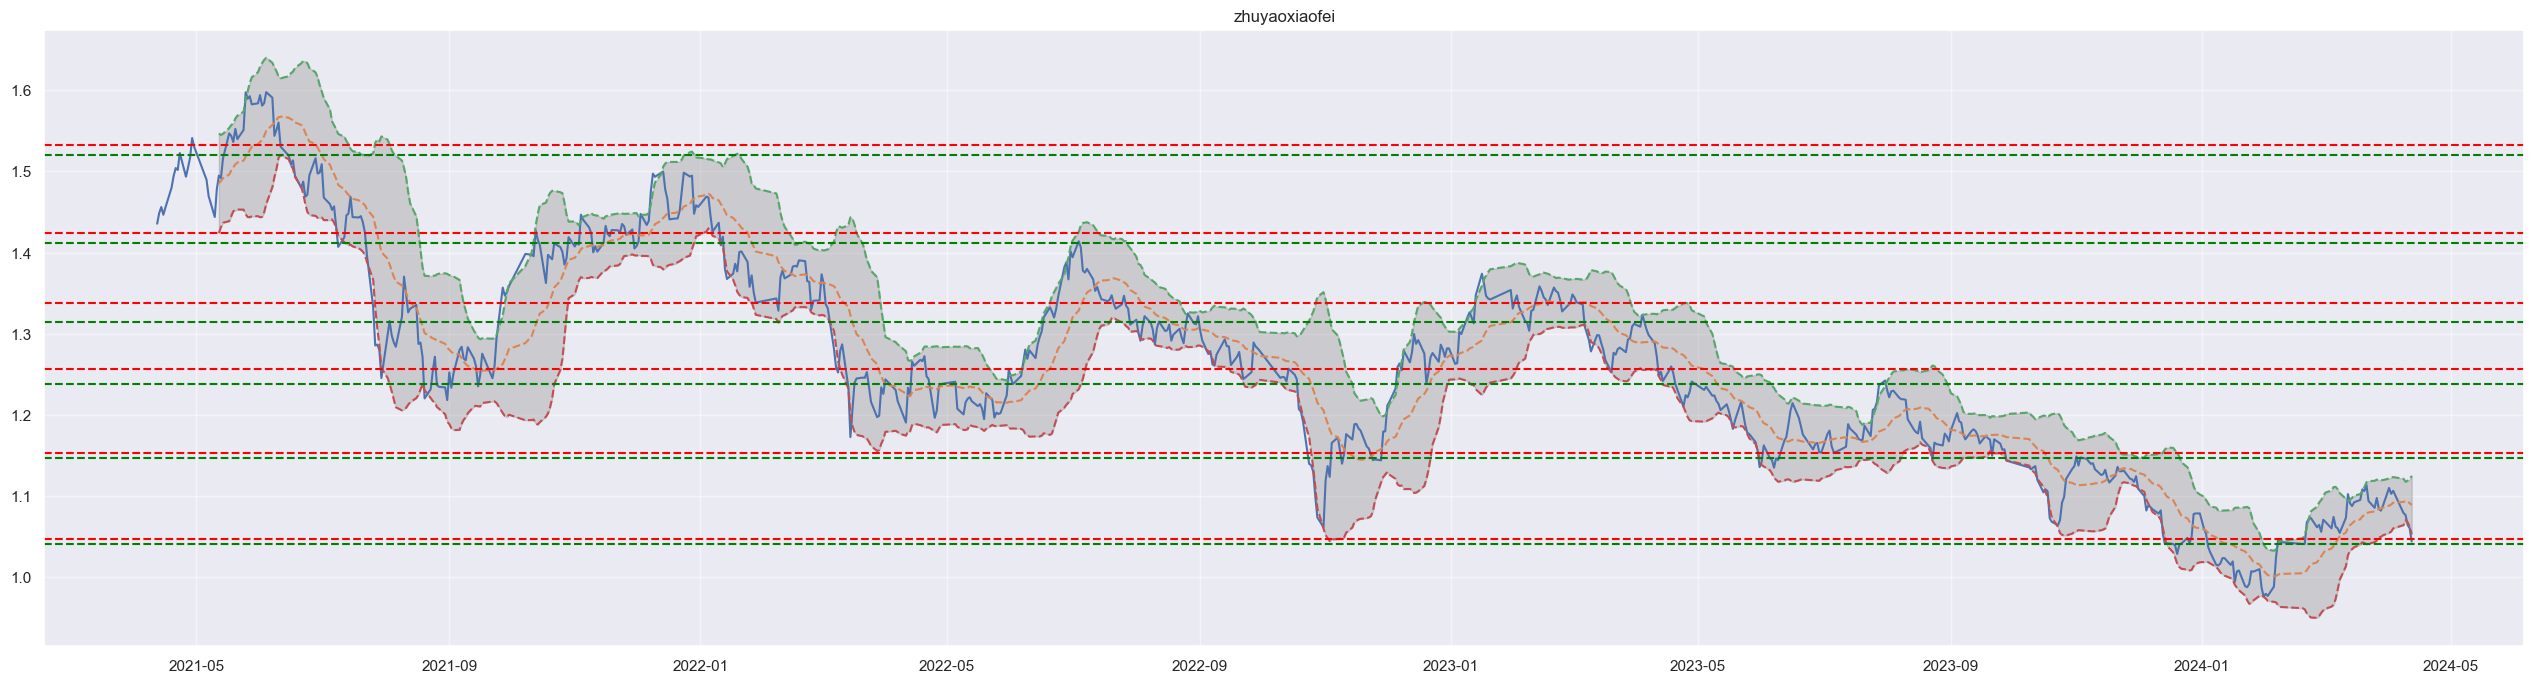

In [24]:
# Target sell: 1.12; buy: 1.067
print(df_fund["name"].unique().tolist()[10])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[10]])

jiadian
2024-04-12
* previous stock price closing 1.19
[[1.05838571]
 [1.13615556]
 [1.19056327]
 [1.28408667]
 [1.43445455]]
[[1.08578919]
 [1.16280192]
 [1.21657273]
 [1.31241923]
 [1.45489565]]
Latest 20 Day MA: 1.1981899999999999
Latest Lower Bollinger Band: 1.1688928364943463
Latest Higher Bollinger Band: 1.2274871635056535


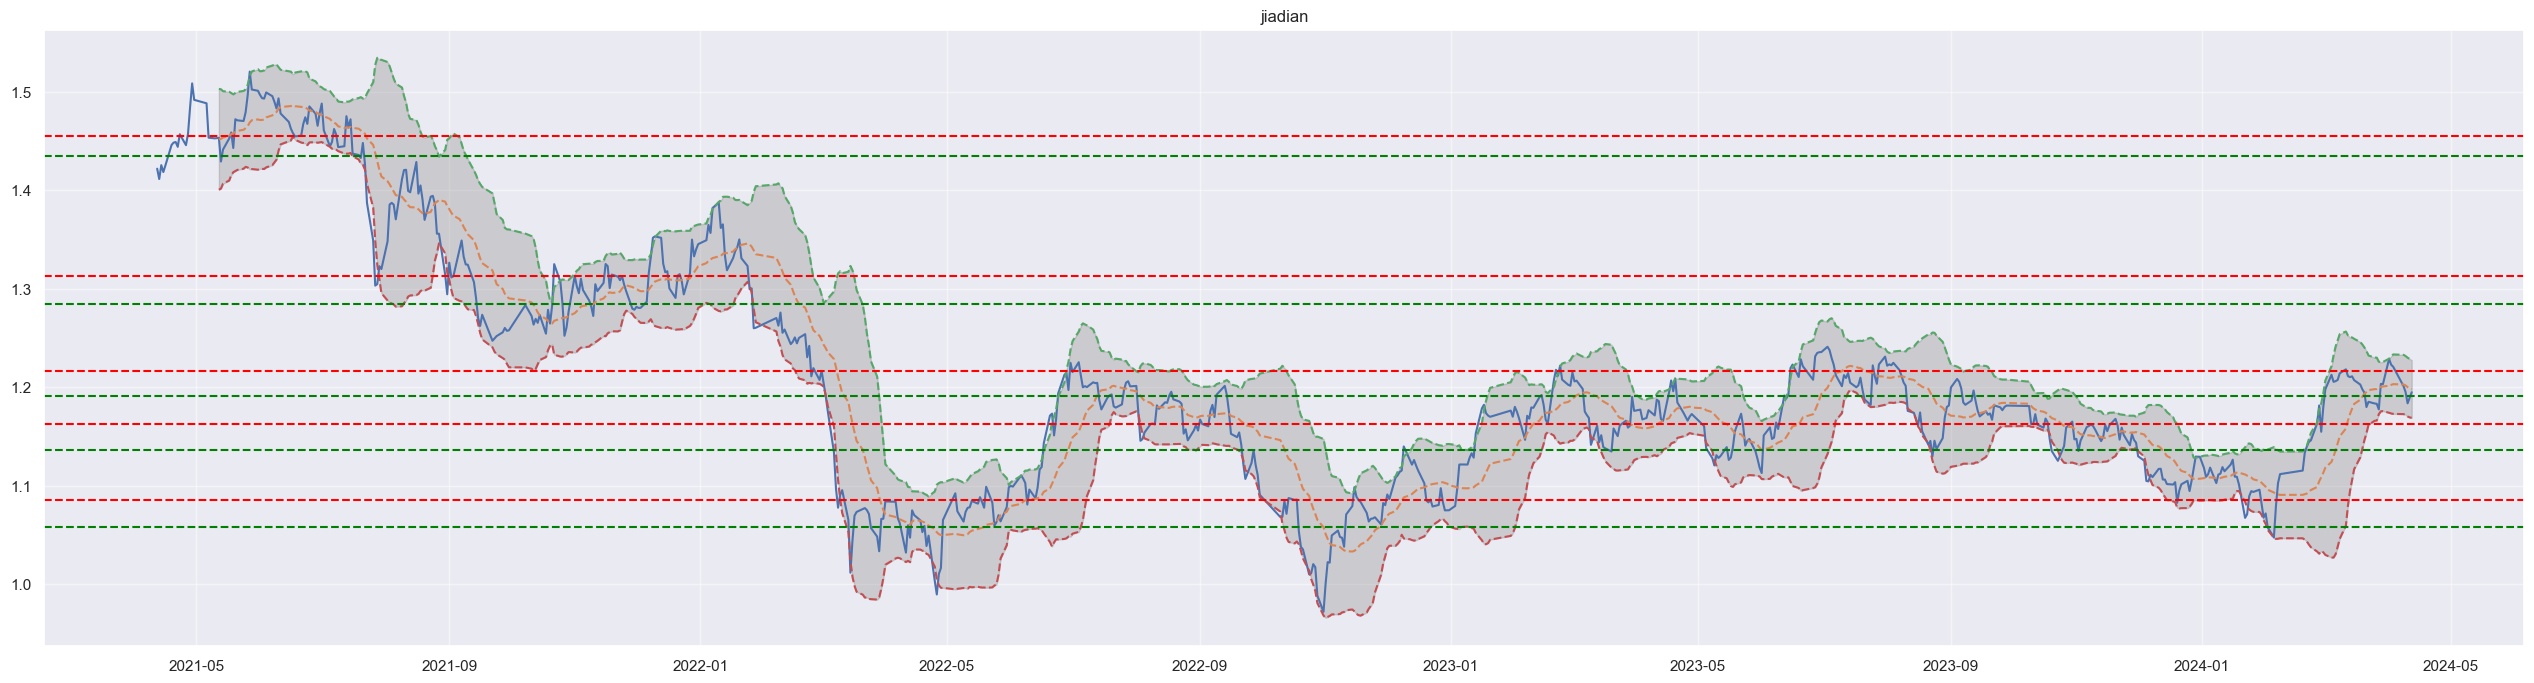

In [25]:
# Target sell: 1.23
# try buy 1.17
# 1.05 solid buy
print(df_fund["name"].unique().tolist()[11])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[11]])

quanzhiyiyao
2024-04-12
* previous stock price closing 0.75
[[0.786135  ]
 [0.86888718]
 [0.94571282]
 [1.00696154]
 [1.16859667]
 [1.31692941]]
[[0.79373529]
 [0.87953333]
 [0.96177209]
 [1.02715641]
 [1.19083548]
 [1.35554706]]
Latest 20 Day MA: 0.776095
Latest Lower Bollinger Band: 0.7369539339359392
Latest Higher Bollinger Band: 0.8152360660640607


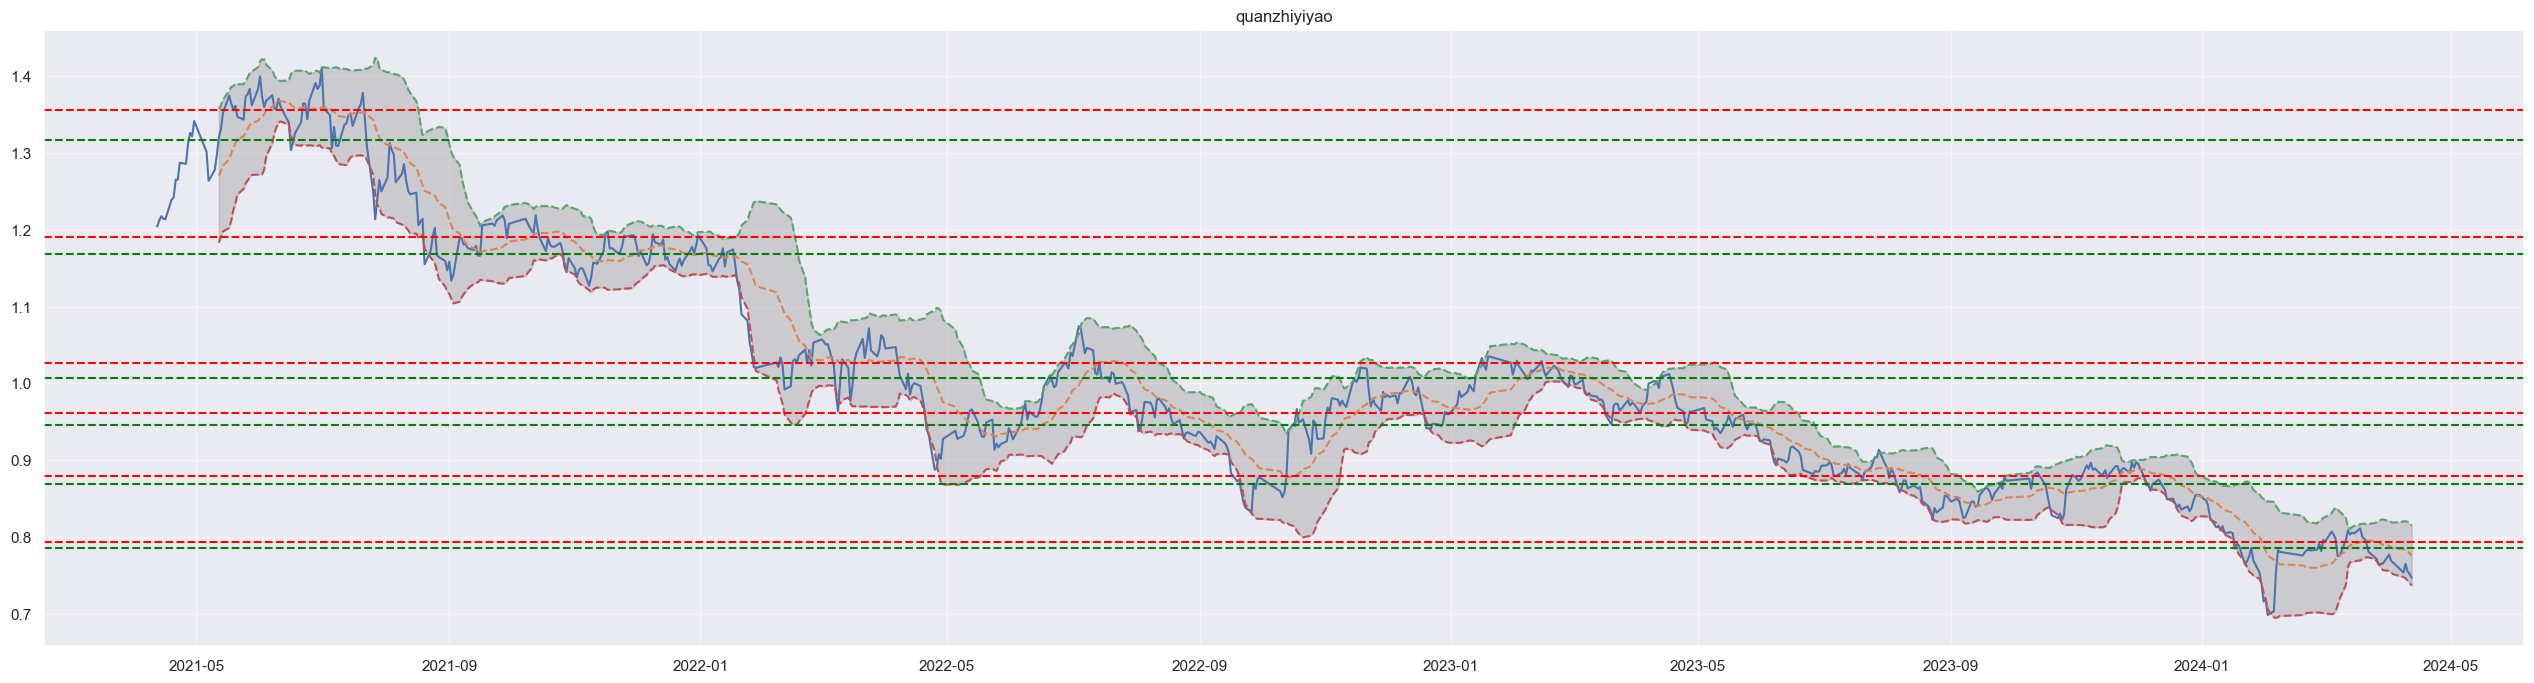

In [26]:
# buy 0.74
# try sell 20 MA 0.784
print(df_fund["name"].unique().tolist()[15])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[15]])

chuangxinyao
2024-04-12
* previous stock price closing 0.78
[[0.81250918]
 [0.93329982]
 [1.024642  ]
 [1.09717436]
 [1.18251075]
 [1.38998658]
 [1.4972643 ]]
[[0.83937559]
 [0.9637926 ]
 [1.07504398]
 [1.18685145]
 [1.38209973]
 [1.48179995]
 [1.63544994]]
Latest 20 Day MA: 0.8235308450490338
Latest Lower Bollinger Band: 0.772832003876422
Latest Higher Bollinger Band: 0.8742296862216457


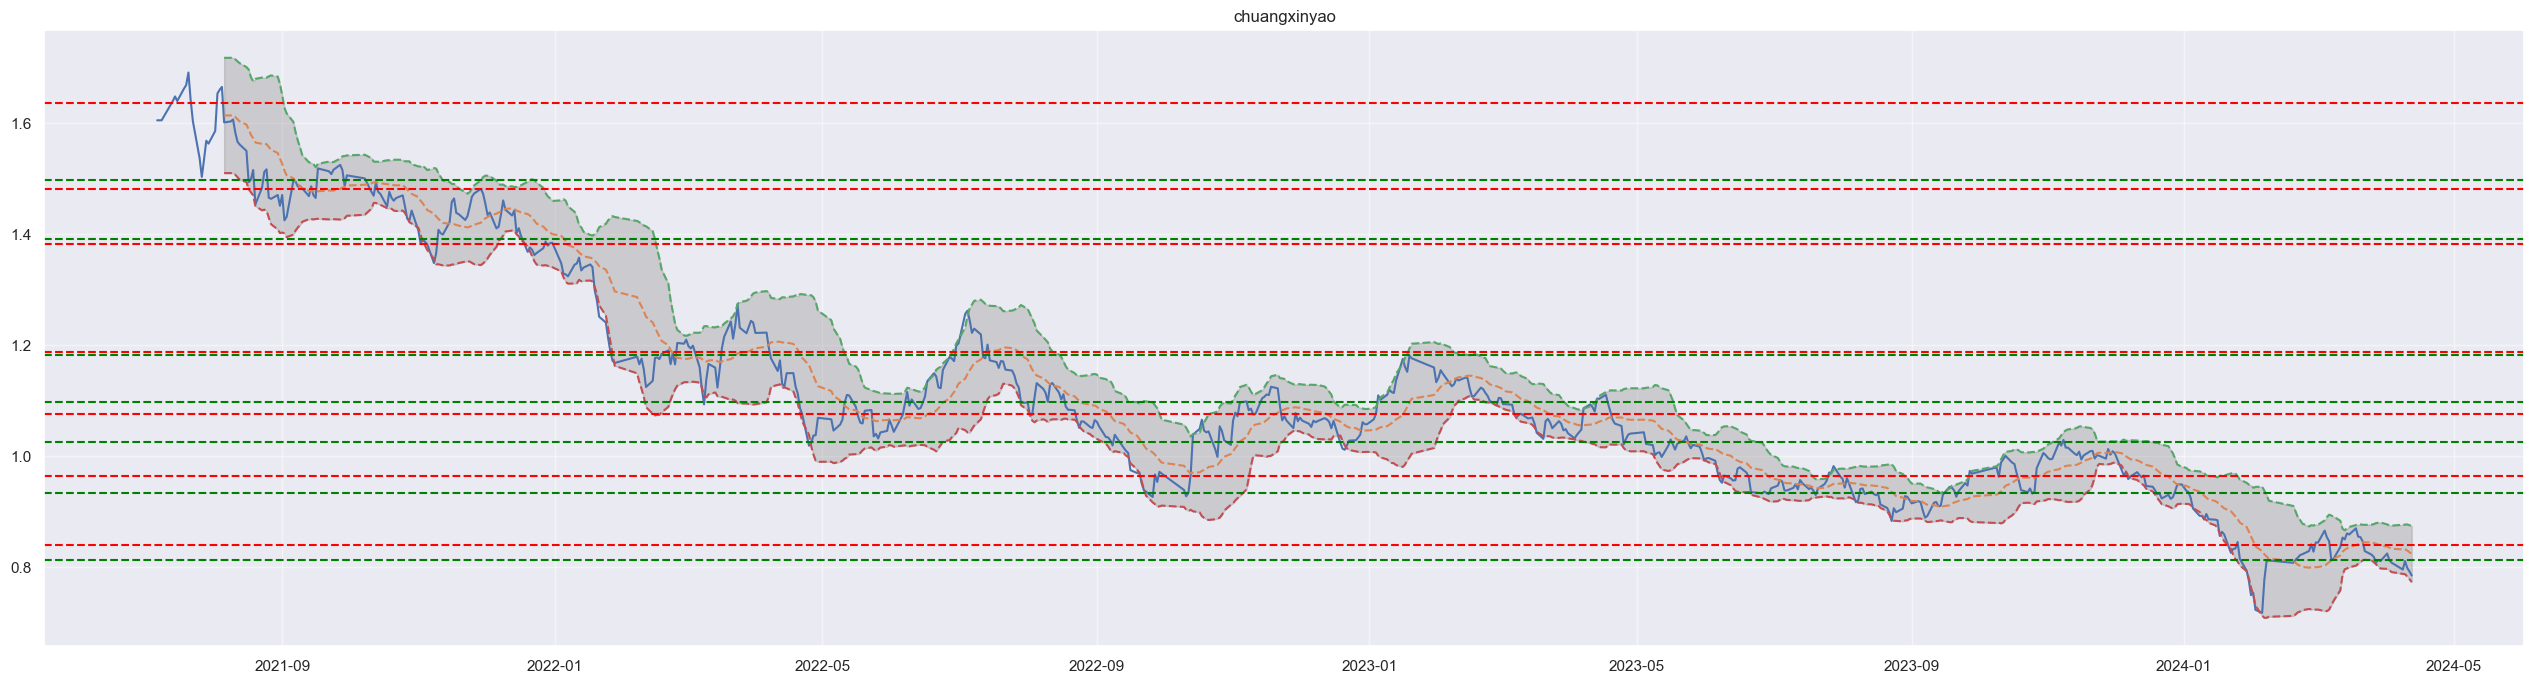

In [27]:
# try buy at Lower Bollinger Band: 0.782
# try sell at 20 MA: 0.832

print(df_fund["name"].unique().tolist()[16])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[16]])

zhongyao
2024-04-12
* previous stock price closing 0.87
[[0.81568202]
 [0.90049742]
 [0.98719915]]
[[0.83925373]
 [0.92500353]
 [1.01366102]]
Latest 20 Day MA: 0.8806219803017162
Latest Lower Bollinger Band: 0.8587521311434441
Latest Higher Bollinger Band: 0.9024918294599884


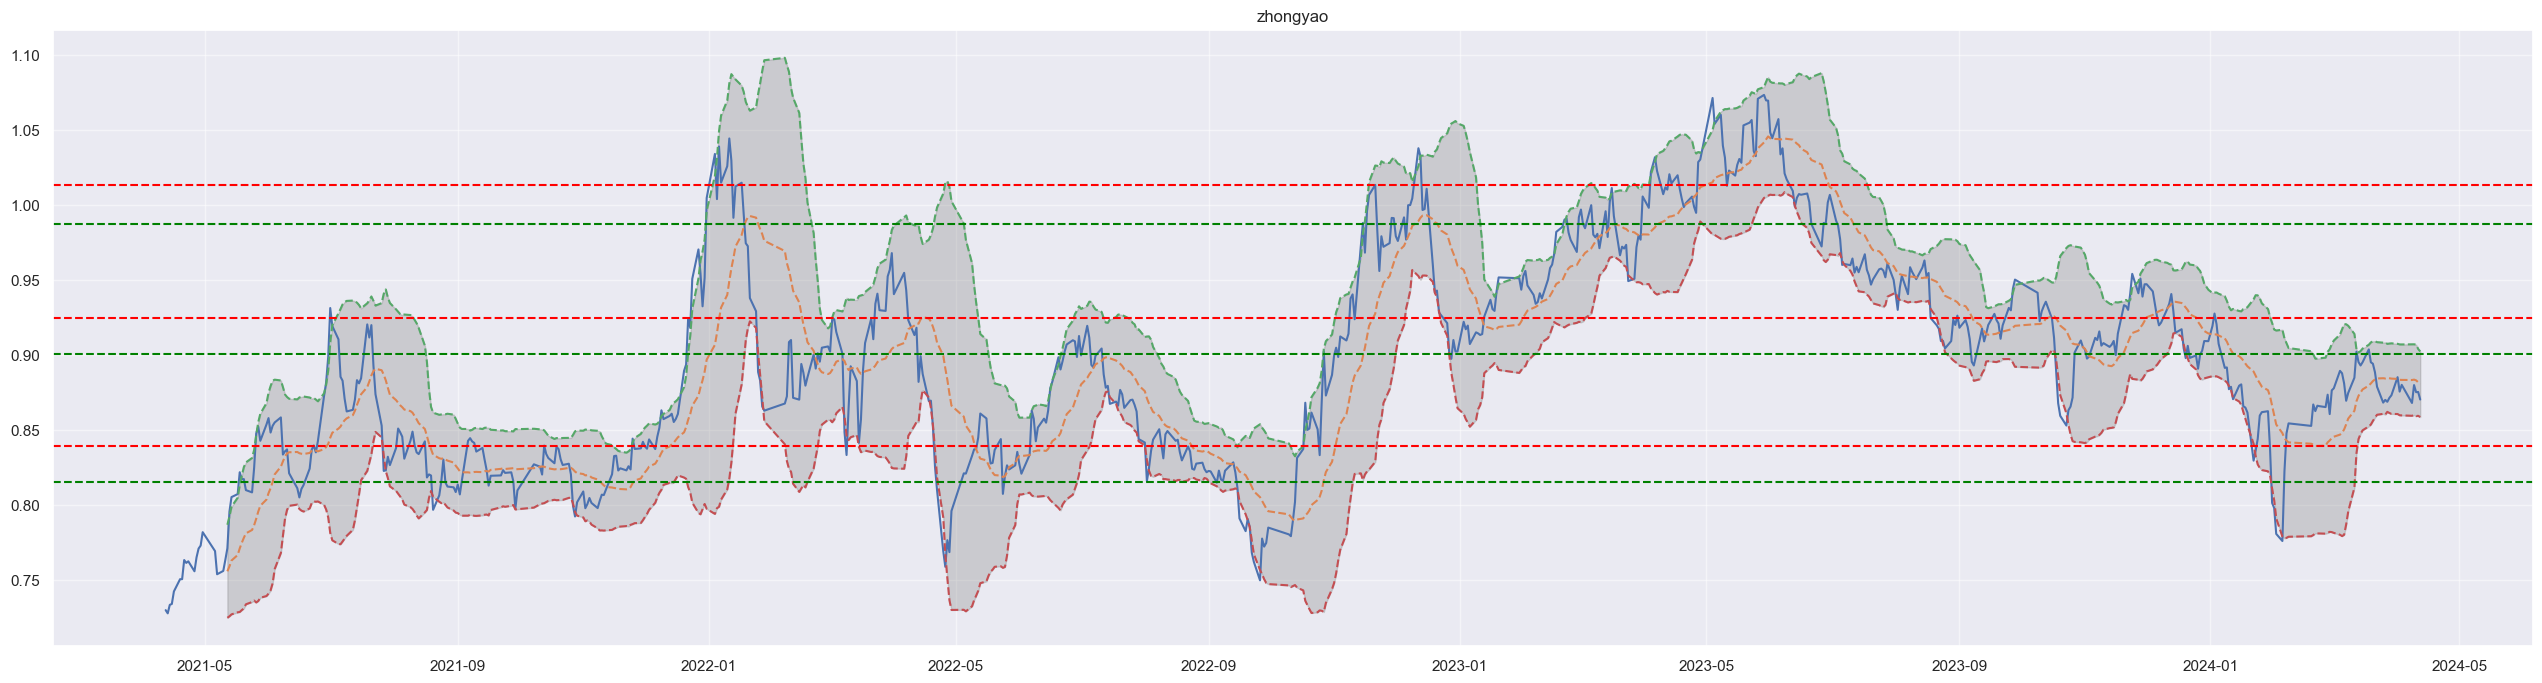

In [28]:
# Try sell at Higher Bollinger Band 0.907
# Try buy at Lower Bollinger Band 0.859
# 20MA: 0.8834
print(df_fund["name"].unique().tolist()[17])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[17]])

chuanmei
2024-04-12
* previous stock price closing 0.72
[[0.60119423]
 [0.70380909]
 [0.7984    ]
 [0.89110526]]
[[0.61396458]
 [0.71586538]
 [0.81396719]
 [0.93233889]]
Latest 20 Day MA: 0.760195
Latest Lower Bollinger Band: 0.7066604179647816
Latest Higher Bollinger Band: 0.8137295820352183


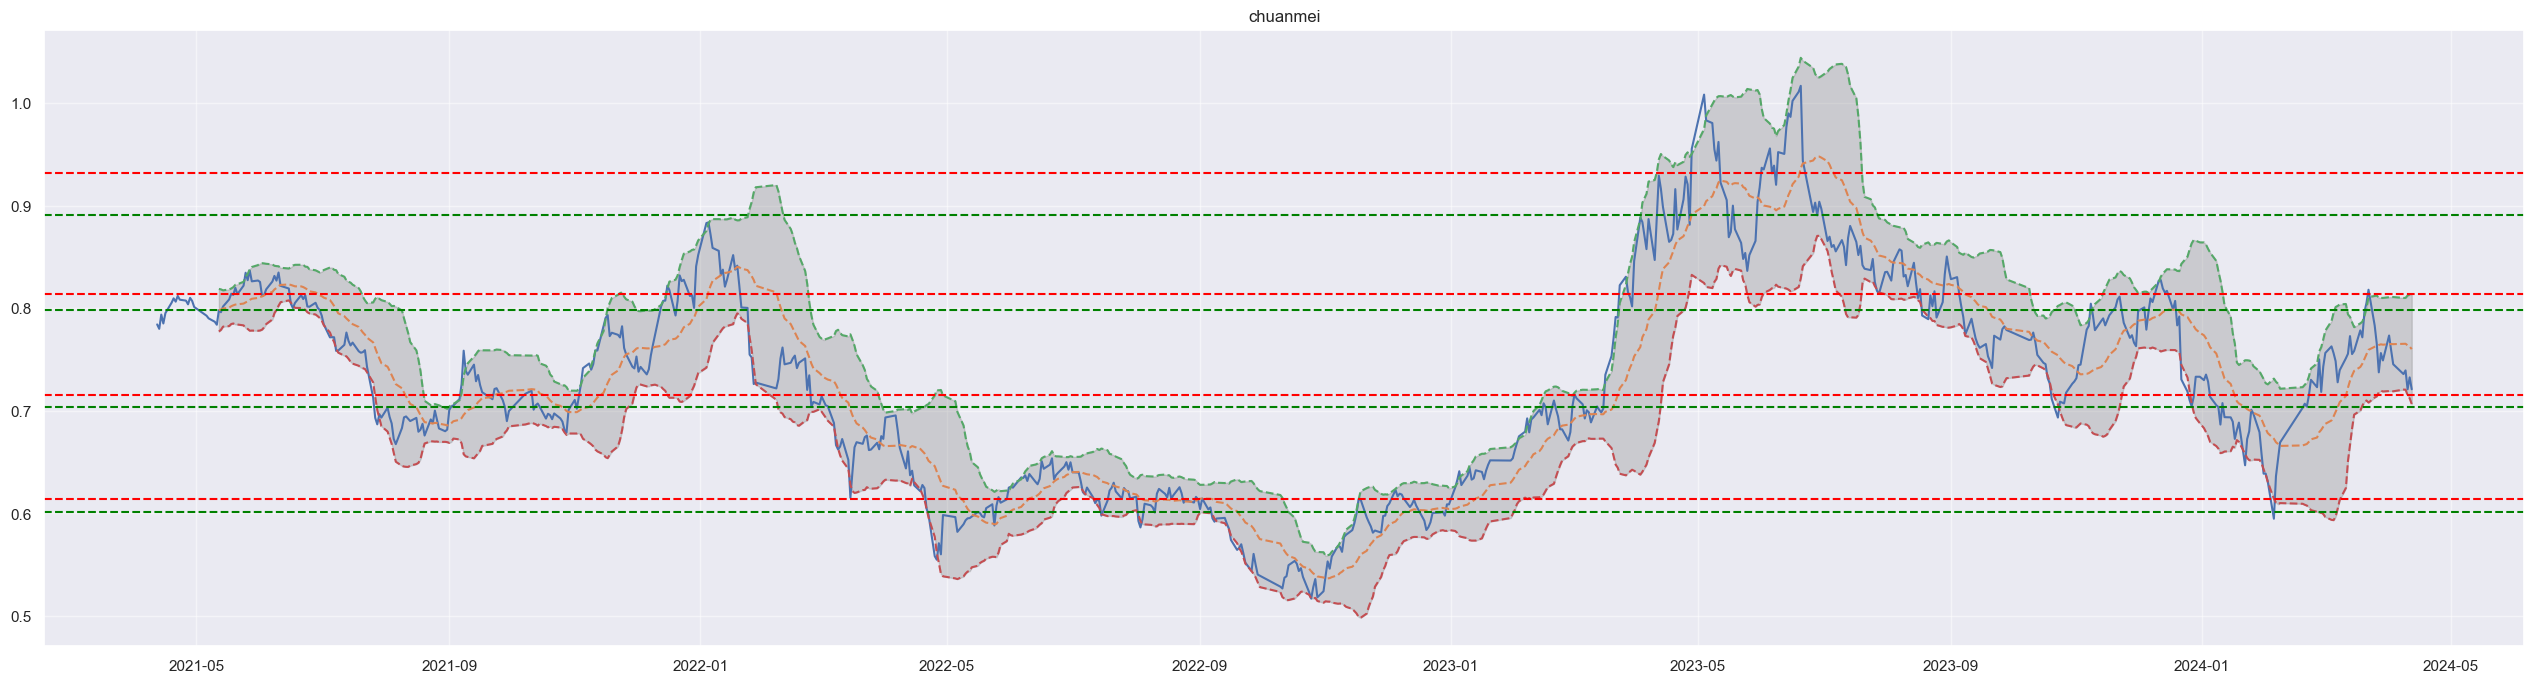

In [29]:
# sell 0.81, buy 0.71; solid buy 0.6
print(df_fund["name"].unique().tolist()[22])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[22]])

yousejinshu
2024-04-12
* previous stock price closing 0.79
[[0.67598857]
 [0.76574   ]
 [0.85813953]
 [0.94977692]]
[[0.68424375]
 [0.7635766 ]
 [0.84614444]
 [0.91819615]
 [1.07173333]]
Latest 20 Day MA: 0.73295
Latest Lower Bollinger Band: 0.6674323205860433
Latest Higher Bollinger Band: 0.7984676794139567


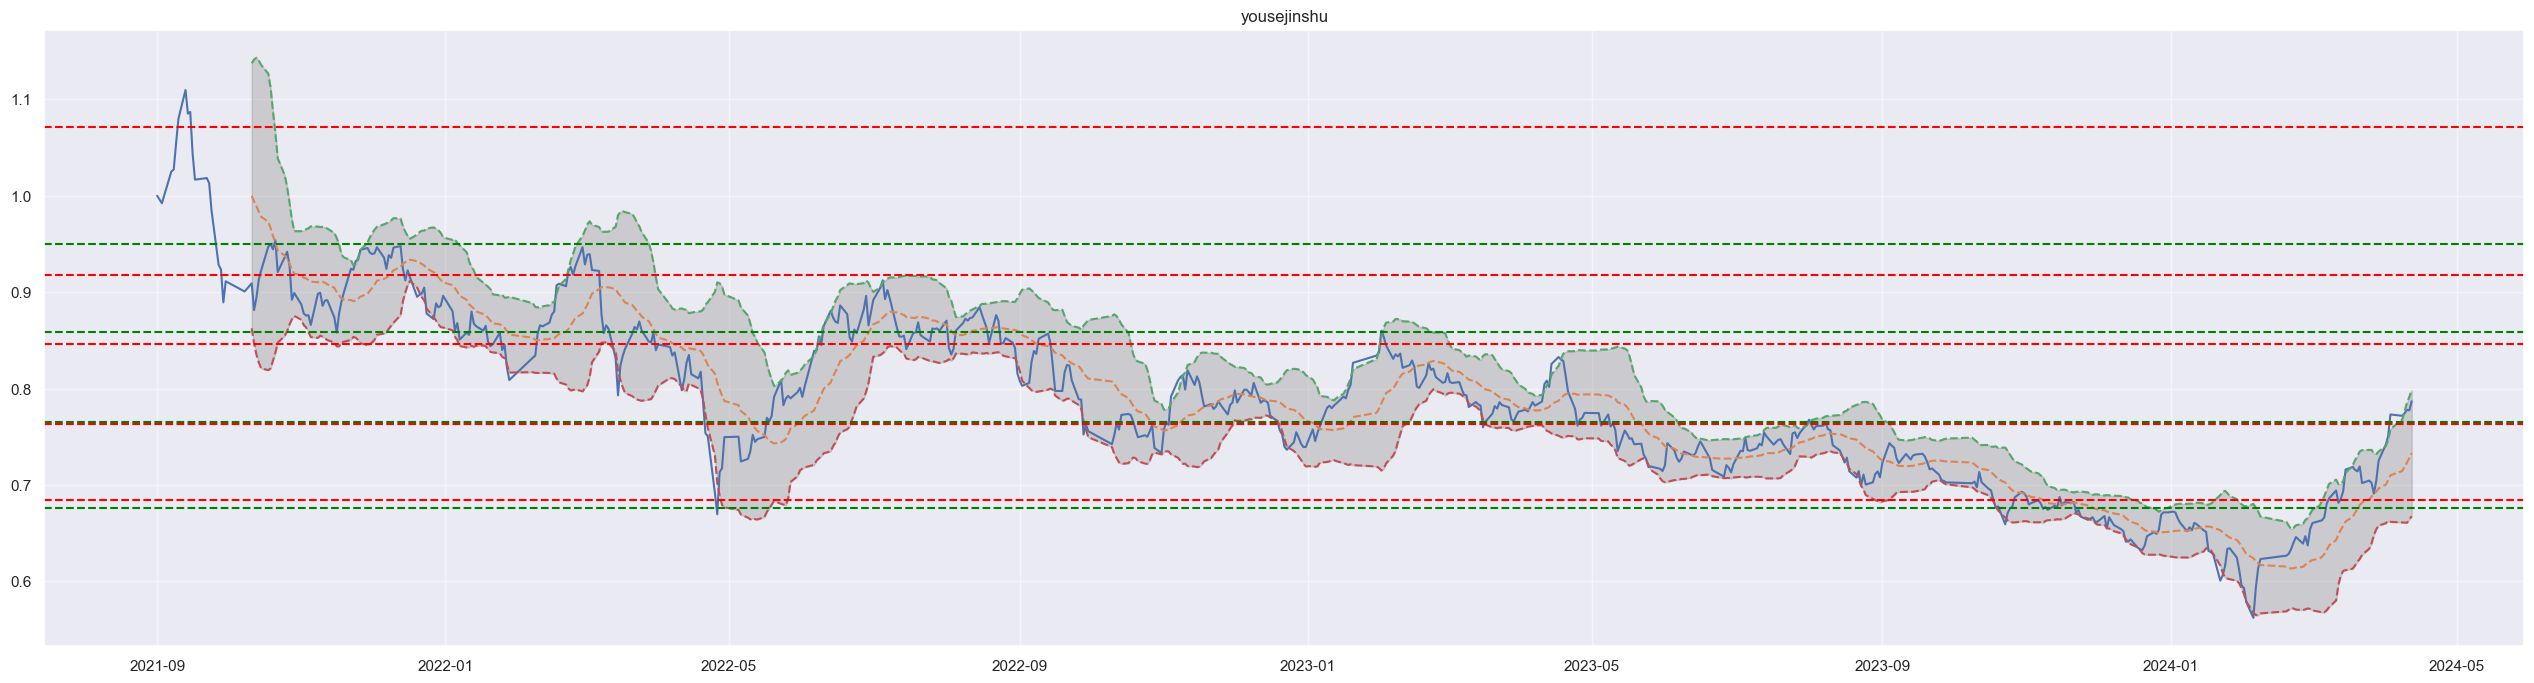

In [30]:
print(df_fund["name"].unique().tolist()[12])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[12]])

ziyuan
2024-04-12
* previous stock price closing 0.79
[[0.67598857]
 [0.76574   ]
 [0.85813953]
 [0.94977692]]
[[0.68424375]
 [0.7635766 ]
 [0.84614444]
 [0.91819615]
 [1.07173333]]
Latest 20 Day MA: 0.73295
Latest Lower Bollinger Band: 0.6674323205860433
Latest Higher Bollinger Band: 0.7984676794139567


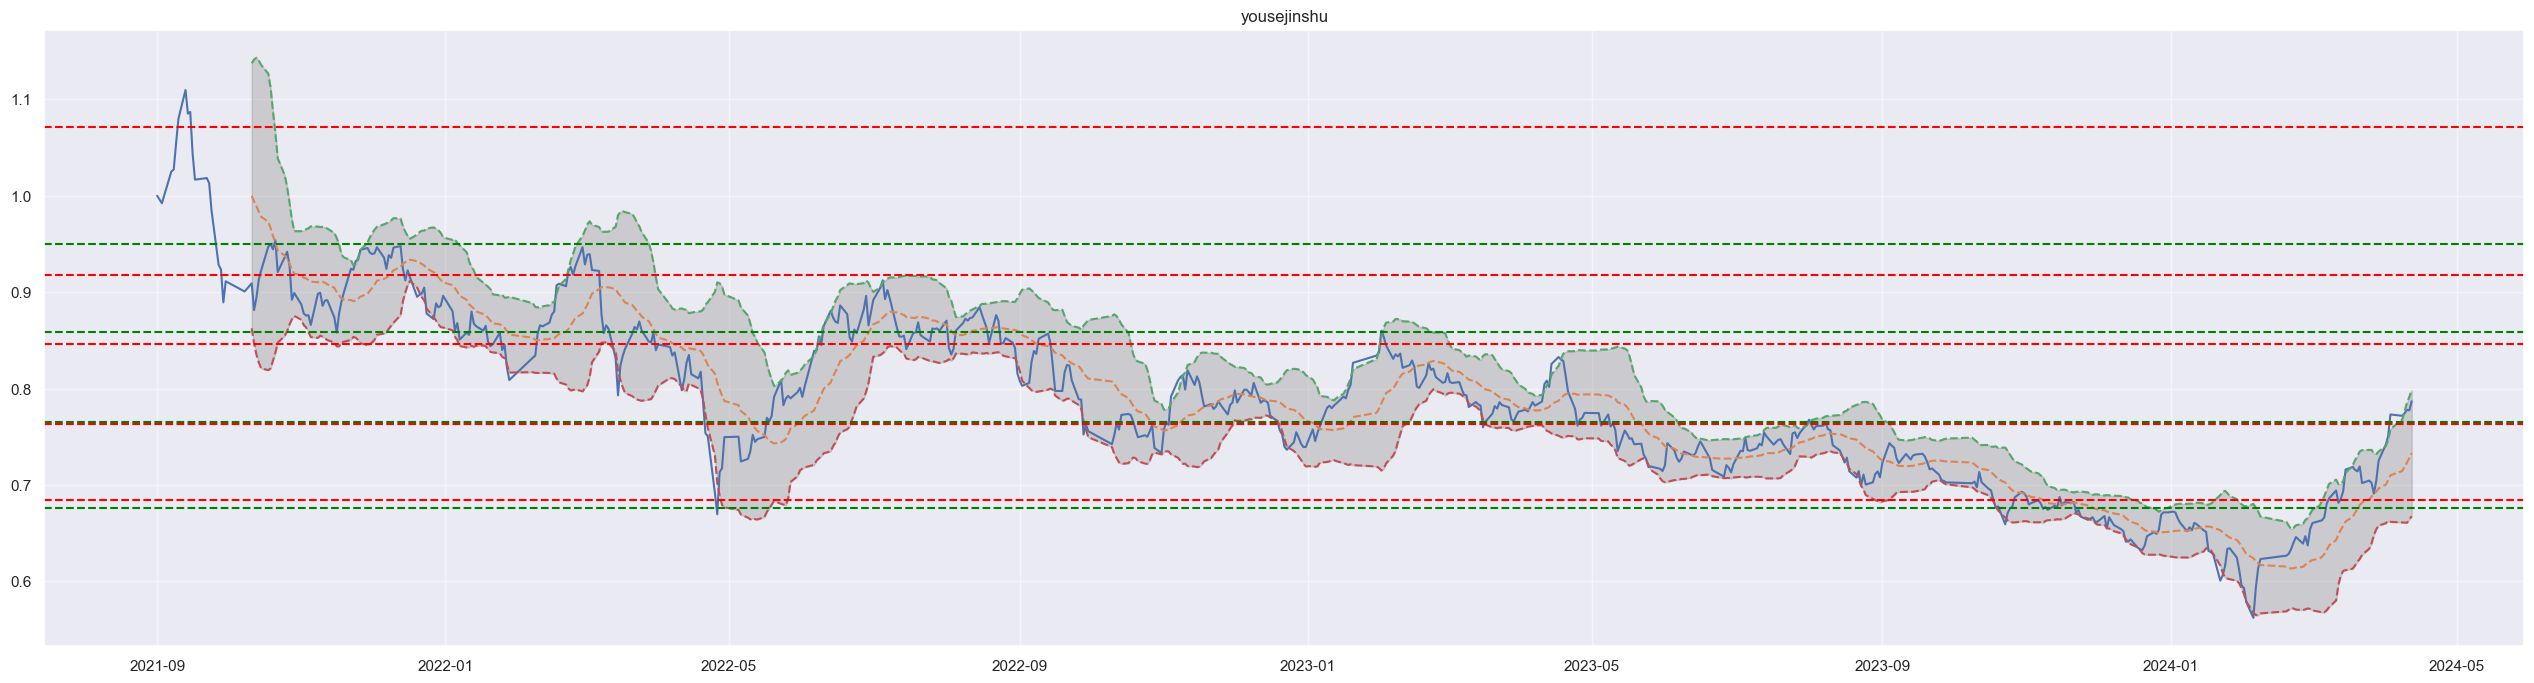

In [31]:
# sell 1.19; solid buy 1.1
print(df_fund["name"].unique().tolist()[13])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[12]])

beizheng 50
2024-04-12
* previous stock price closing 0.88
[[0.8545    ]
 [0.96636571]
 [1.05413846]]
[[0.875905  ]
 [0.98022857]
 [1.08254375]]
Latest 20 Day MA: 0.916855
Latest Lower Bollinger Band: 0.8620620509722506
Latest Higher Bollinger Band: 0.9716479490277493


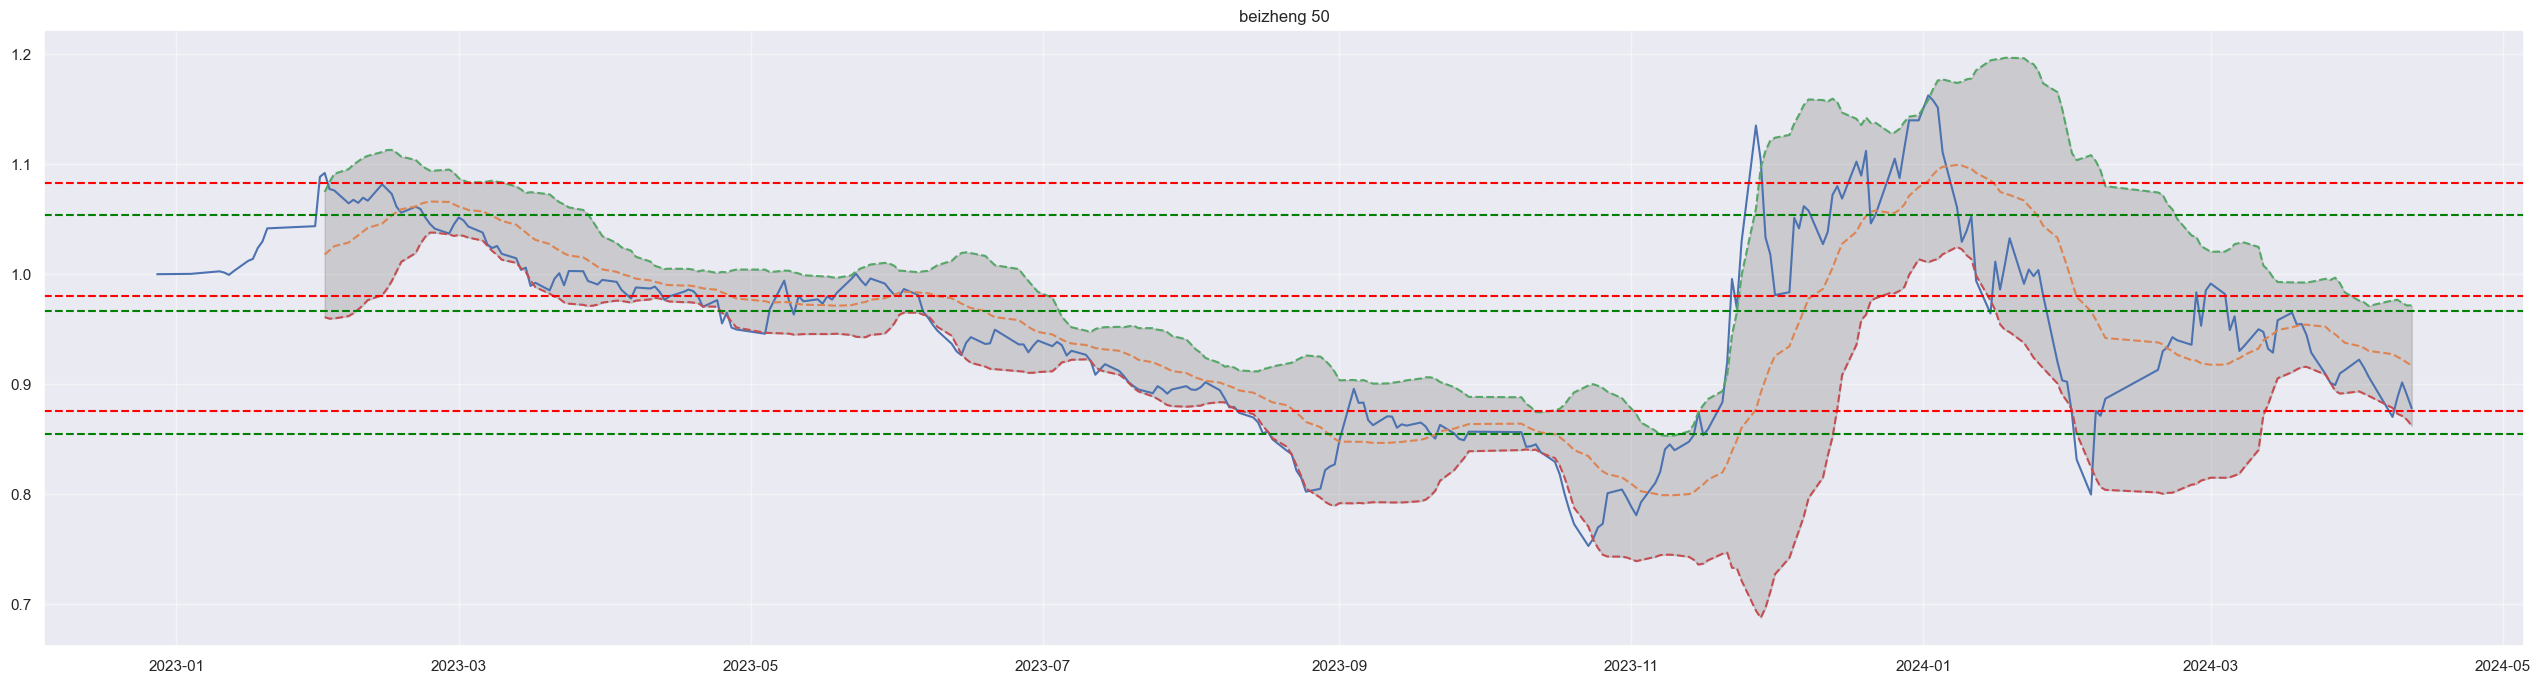

In [32]:
# Try 0.873- buy
# sell 20MA 0.92
print(df_fund["name"].unique().tolist()[20])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[20]])

In [33]:
def calculate_investment_return(stock_prices, purchase_interval, investment_amount, start_date, end_date):
    # Filter stock prices between start and end date
    stock_prices = stock_prices[stock_prices['date'].between(start_date,end_date)]
    

    # Initialize variables
    total_investment = 0
    num_shares = 0
    daily_investment_value = list()
    daily_investment_amt = list()    
    last_purchase_date = None

    # Iterate over stock prices
    for idx, row in stock_prices.iterrows():
        # Check if it's time to make a purchase
        if last_purchase_date is None or (row['date'] - last_purchase_date).days >= purchase_interval:
            # Calculate number of shares to purchase
            num_shares += investment_amount / row['price']
            total_investment += investment_amount      
            last_purchase_date = row['date']
        else:
            num_shares += 0
            total_investment += 0
        
        # Calculate daily investment value
        daily_investment_value.append(num_shares * row['price'])
        daily_investment_amt.append(total_investment)

    df_strategy = stock_prices.copy()
    df_strategy['investment_value'] = daily_investment_value
    df_strategy['investment_amt_sofar'] = daily_investment_amt
    df_strategy['revenue'] = df_strategy['investment_value'] - df_strategy['investment_amt_sofar']
    df_strategy['revenue%'] = df_strategy['revenue'] / df_strategy['investment_amt_sofar']
    return df_strategy

### 定投

In [34]:
dict_autogood_2021 = dict()
for e in df_fund["name"].unique().tolist():
#     print(e)
    df_stock = df_fund[df_fund["name"]==e].sort_values(by='date').reset_index()
    if e == 'hongli':
        df_stock['price'] = df_stock['NAV-Cum']
    else:
        df_stock['price'] = df_stock['NAV']
    if df_stock['date'].min() > pd.to_datetime('2021-01-01'):
#         print("History too short, skip")
        pass
    else:        
        stock_strategy =  calculate_investment_return(df_stock[['date','price']],
                                                      purchase_interval=7, 
                                                      investment_amount=500, 
                                                      start_date='2021-01-01', 
                                                      end_date=datetime.today().strftime('%Y-%m-%d'))
#         print(stock_strategy['revenue%'].min())
#         print(stock_strategy.iloc[-1]['revenue%'])
        if stock_strategy.iloc[-1]['revenue%'] > 0:
            dict_autogood_2021[e] = stock_strategy.iloc[-1]['revenue%']
dict_autogood_2021

{'500dibo': 0.002893016156849141,
 'tongxinshebei': 0.14735064960437982,
 'honglidibo': 0.23752237733315718,
 'hongli': 0.12608371043436487,
 'huangjinchanye': 0.36734375827932186}

In [35]:
dict_autogood_2022 = dict()
for e in df_fund["name"].unique().tolist():
#     print(e)
    df_stock = df_fund[df_fund["name"]==e].sort_values(by='date').reset_index()
    if e == 'hongli':
        df_stock['price'] = df_stock['NAV-Cum']
    else:
        df_stock['price'] = df_stock['NAV']
    if df_stock['date'].min() > pd.to_datetime('2022-01-01'):
#         print("History too short, skip")
        pass
    else:
        stock_strategy =  calculate_investment_return(df_stock[['date','NAV']].rename(columns={'NAV':'price'}),
                                                      purchase_interval=7, 
                                                      investment_amount=500, 
                                                      start_date='2022-01-01', 
                                                      end_date=datetime.today().strftime('%Y-%m-%d'))
#         print(stock_strategy['revenue%'].min())
#         print(stock_strategy.iloc[-1]['revenue%'])
        if stock_strategy.iloc[-1]['revenue%'] > 0:
            dict_autogood_2022[e] = stock_strategy.iloc[-1]['revenue%']
dict_autogood_2022

{'jiadian': 0.04101248123953817,
 'yousejinshu': 0.03486892113531798,
 'ziyuan': 0.11222428299952608,
 'tongxinshebei': 0.15824305259933813,
 'honglidibo': 0.16167208090149698,
 'hongli': 0.05087689233151372,
 'huangjinchanye': 0.31579992556034414,
 'chuanmei': 0.02971144629707864}

### 网格

In [36]:
import sys
sys.path.append('../src') 
from utils import stock_trading_strategy
dict_gridgood_2021 = dict()

for e in df_fund["name"].unique().tolist():
#     print(e)
    df_stock = df_fund[df_fund["name"]==e].sort_values(by='date').reset_index()
    if e == 'hongli':
        df_stock['daily_price'] = df_stock['NAV-Cum']
    else:
        df_stock['daily_price'] = df_stock['NAV']
    if df_stock['date'].min() > pd.to_datetime('2021-01-01'):
#         print("History too short, skip")
        pass
    else:
        result =  stock_trading_strategy(df_stock[['date','daily_price']],
                                         start_date='2021-01-01',
                                         end_date=datetime.today().strftime('%Y-%m-%d'))
#         print((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000)
        if (result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000 > 0:
            dict_gridgood_2021[e] = (result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000
dict_gridgood_2021

{'zhongzheng 500': 493.47261263459586,
 '500dibo': 223.59834000046249,
 'bandaoti - zhongzheng': 428.3669162165097,
 'rengongzhineng': 915.5035868471314,
 'jiadian': 523.0732323592001,
 'tongxinshebei': 1733.712887020938,
 'zhongyao': 118.7738559110694,
 'honglidibo': 57.86035462797918,
 'hongli': 51.475568456700785,
 'huangjinchanye': 233.94941718200607,
 'chuanmei': 1618.797160636408}

In [37]:
import sys
sys.path.append('../src') 
from utils import stock_trading_strategy
dict_gridgood_2022 = dict()

for e in df_fund["name"].unique().tolist():
#     print(e)
    df_stock = df_fund[df_fund["name"]==e].sort_values(by='date').reset_index()
    if e == 'hongli':
        df_stock['daily_price'] = df_stock['NAV-Cum']
    else:
        df_stock['daily_price'] = df_stock['NAV']
    if df_stock['date'].min() > pd.to_datetime('2022-01-01'):
#         print("History too short, skip")
        pass
    else:
        result =  stock_trading_strategy(df_stock[['date','daily_price']],
                                         start_date='2022-01-01',
                                         end_date=datetime.today().strftime('%Y-%m-%d'))
#         print((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000)
        if (result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000 > 0:
            dict_gridgood_2022[e] = (result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000
dict_gridgood_2022

{'zhongzheng 500': 16.501554590478918,
 '500dibo': 432.5198353822889,
 'zhinengqiche': 376.2607844420163,
 'rengongzhineng': 250.98719198160325,
 'jiadian': 427.54016235567906,
 'yousejinshu': 920.0481395721654,
 'ziyuan': 1000.496112555511,
 'tongxinshebei': 1665.4242851538438,
 'zhongyao': 642.7239531940832,
 'honglidibo': 274.6751712833284,
 'hongli': 321.02622060894646,
 'huangjinchanye': 115.33622854761234,
 'chuanmei': 1310.467385596059}

##### 红利低波 - 定投
创金合信 1.8 买入

易方达 = 0.07927750001695077 + 0.504527891091394*test

0.987 买入

2024-04-12
* previous stock price closing 1.9
[[1.35485667]
 [1.49157105]
 [1.56077391]
 [1.6982902 ]
 [1.82149   ]]
[[1.37115926]
 [1.49860833]
 [1.56919298]
 [1.677244  ]
 [1.74588333]
 [1.85788   ]]
Latest 20 Day MA: 1.84878
Latest Lower Bollinger Band: 1.7928583405110268
Latest Higher Bollinger Band: 1.9047016594889734
Latest regression: [1.80743531]
Annual return rate: 0.1495553355622013


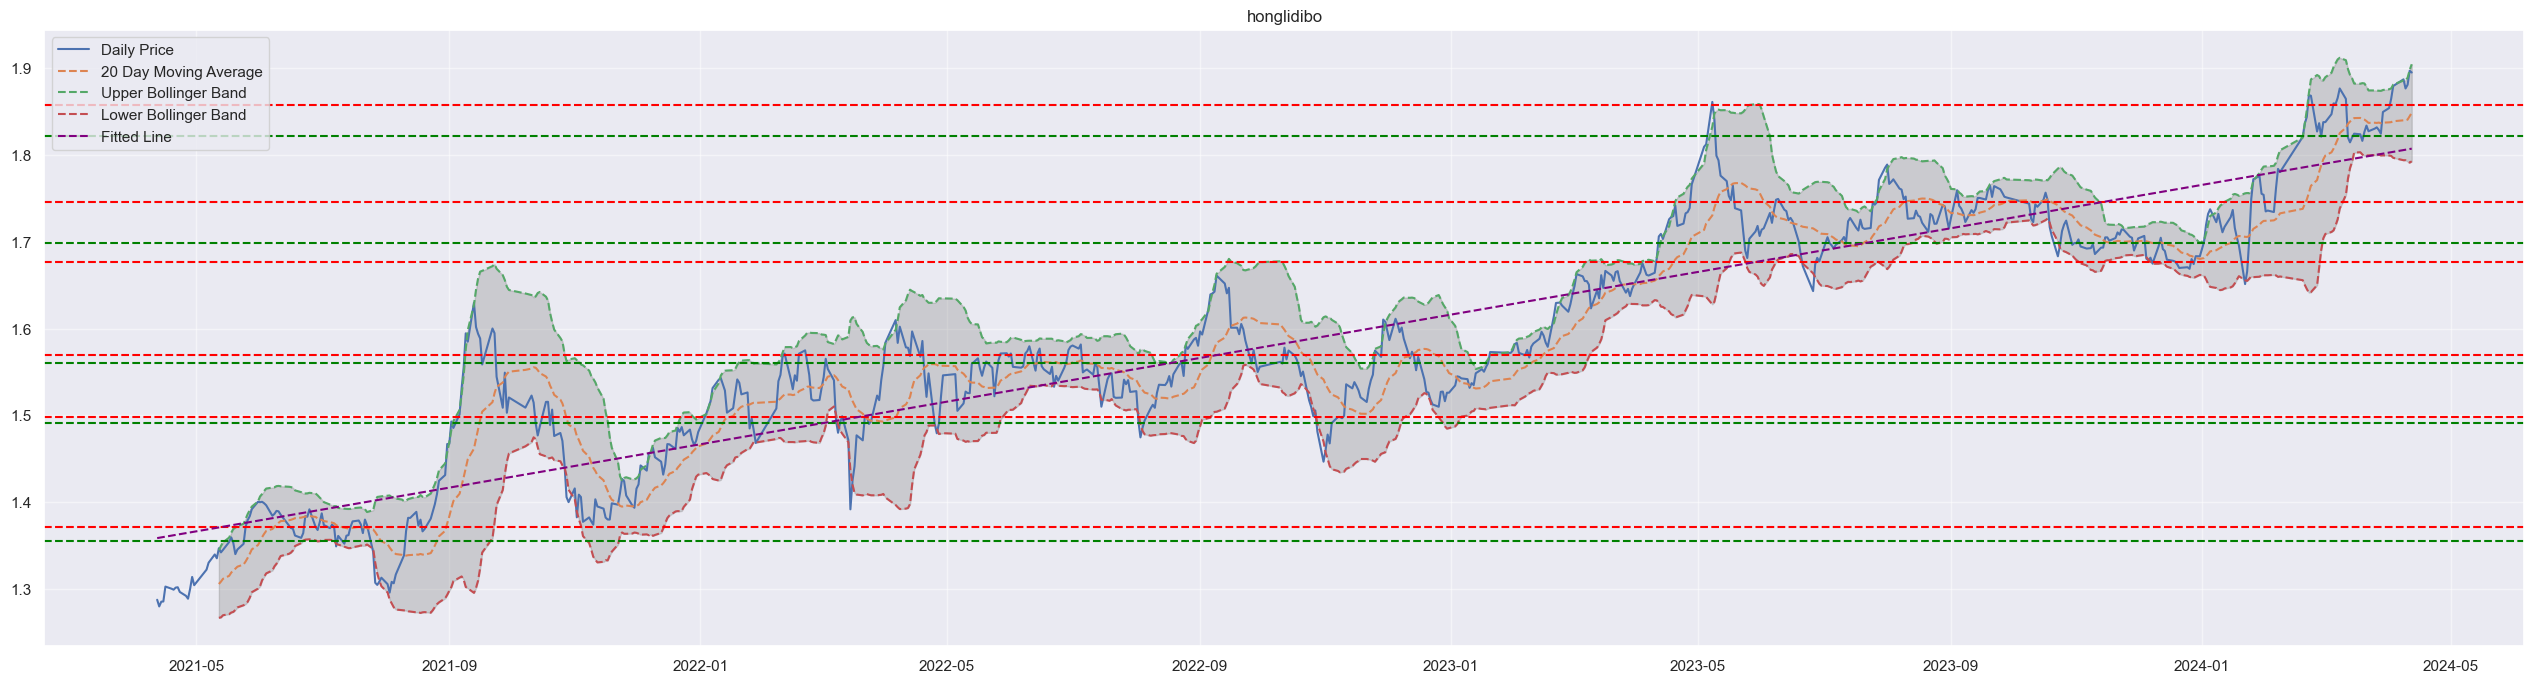

In [38]:
stock_df = df_fund[df_fund["name"]=='honglidibo']
start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d')
# start=df_fund['date'].min()

df = stock_df[stock_df['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
df = df.sort_values(by='date').reset_index()
df['daily_price'] = df['NAV']

print(datetime.today().strftime('%Y-%m-%d'))
print('* previous stock price closing', round(df.iloc[-1]['daily_price'],2))

# Support and Resistance
df = identify_weak_support_resistance(df)
low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"daily_price"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"daily_price"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

df['20 Day MA'] = df['NAV'].rolling(window=20).mean()
df['20 Day STD'] = df['NAV'].rolling(window=20).std()
    
# Calculate upper and lower bands
df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])

print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])

fig, ax = plt.subplots(figsize=(32,8))

# fit a trend line
df['date_numeric'] = pd.to_numeric(df['date'])
X = df['date_numeric'].values.reshape(-1, 1)  # Feature matrix (date)
y = df['NAV'].values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]
print("Latest regression:", X_b.dot(theta_best)[-1])

print("Annual return rate:", (X_b.dot(theta_best)[-1]-X_b.dot(theta_best)[0])[0]/((datetime.today()-pd.to_datetime(start)).days/365.2425))
# All time: Annual return rate: 0.11558604215459481

ax.grid(True, alpha=0.5)
ax.set_title(stock_df['name'].unique()[0])
ax.plot(df['date'], df['NAV'], label='Daily Price')
ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
ax.plot(df['date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
ax.plot(df['date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
ax.fill_between(df['date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')
    
ax.plot(df['date'], X_b.dot(theta_best), ls='--', color='purple', label='Fitted Line')
ax.legend()
ax.grid(True)

##### 红利 - 定投

2024-04-12
* previous stock price closing 1.37
[[1.14962558]
 [1.21317123]
 [1.28561967]]
[[1.18534857]
 [1.25460811]
 [1.3229697 ]]
Latest 20 Day MA: 1.347615
Latest Lower Bollinger Band: 1.3243929347217185
Latest Higher Bollinger Band: 1.3708370652782815
Annual return rate: 0.05217483647546499
Latest regression: [1.31271419]


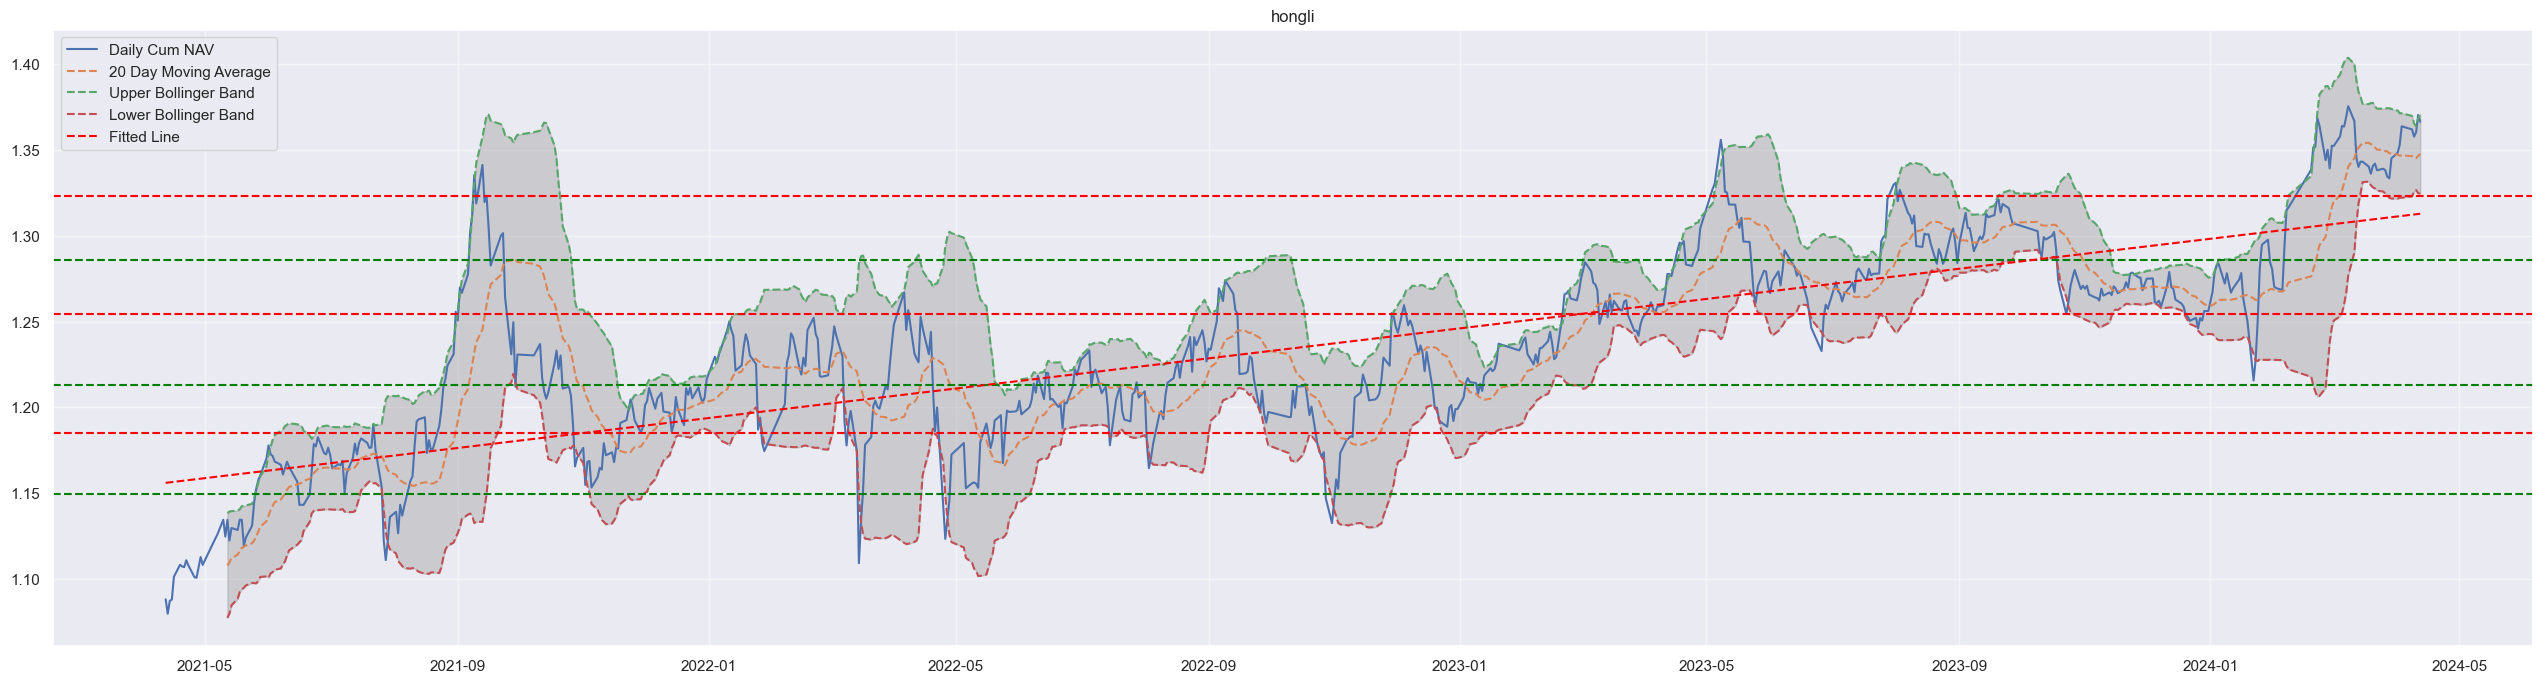

In [39]:
stock_df = df_fund[df_fund["name"]=='hongli']
start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d')
# start=df_fund['date'].min()

df = stock_df[stock_df['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
df = df.sort_values(by='date').reset_index()
df['daily_price'] = df['NAV-Cum']

print(datetime.today().strftime('%Y-%m-%d'))
print('* previous stock price closing', round(df.iloc[-1]['daily_price'],2))

# Support and Resistance
df = identify_weak_support_resistance(df)
low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"daily_price"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"daily_price"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

# For hongli, need to use NAV-Cum
df['20 Day MA'] = df['NAV-Cum'].rolling(window=20).mean()
df['20 Day STD'] = df['NAV-Cum'].rolling(window=20).std()
    
# Calculate upper and lower bands
df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])

print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])
fig, ax = plt.subplots(figsize=(32,8))

# fit a trend line
df['date_numeric'] = pd.to_numeric(df['date'])
X = df['date_numeric'].values.reshape(-1, 1)  # Feature matrix (date)
y = df['NAV-Cum'].values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]

print("Annual return rate:", (X_b.dot(theta_best)[-1]-X_b.dot(theta_best)[0])[0]/((datetime.today()-pd.to_datetime(start)).days/365.2425))
# All time: Annual return rate: 0.03184651573698018
print("Latest regression:", X_b.dot(theta_best)[-1])

ax.grid(True, alpha=0.5)
ax.set_title(stock_df['name'].unique()[0])
ax.plot(df['date'], df['NAV-Cum'], label='Daily Cum NAV')
ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
ax.plot(df['date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
ax.plot(df['date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
ax.fill_between(df['date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')
    
ax.plot(df['date'], X_b.dot(theta_best), ls='--', color='red', label='Fitted Line')
ax.legend()
ax.grid(True)

##### 黄金

2024-04-12
* previous stock price closing 1.92
[[1.29452027]
 [1.38062128]
 [1.52895484]
 [1.60952308]
 [1.76746667]]
[[1.30619167]
 [1.39385306]
 [1.54375862]
 [1.62002857]
 [1.77105   ]]
Latest 20 Day MA: 1.786775
Latest Lower Bollinger Band: 1.6485042073311953
Latest Higher Bollinger Band: 1.9250457926688047
Annual return rate: 0.14490485238355855


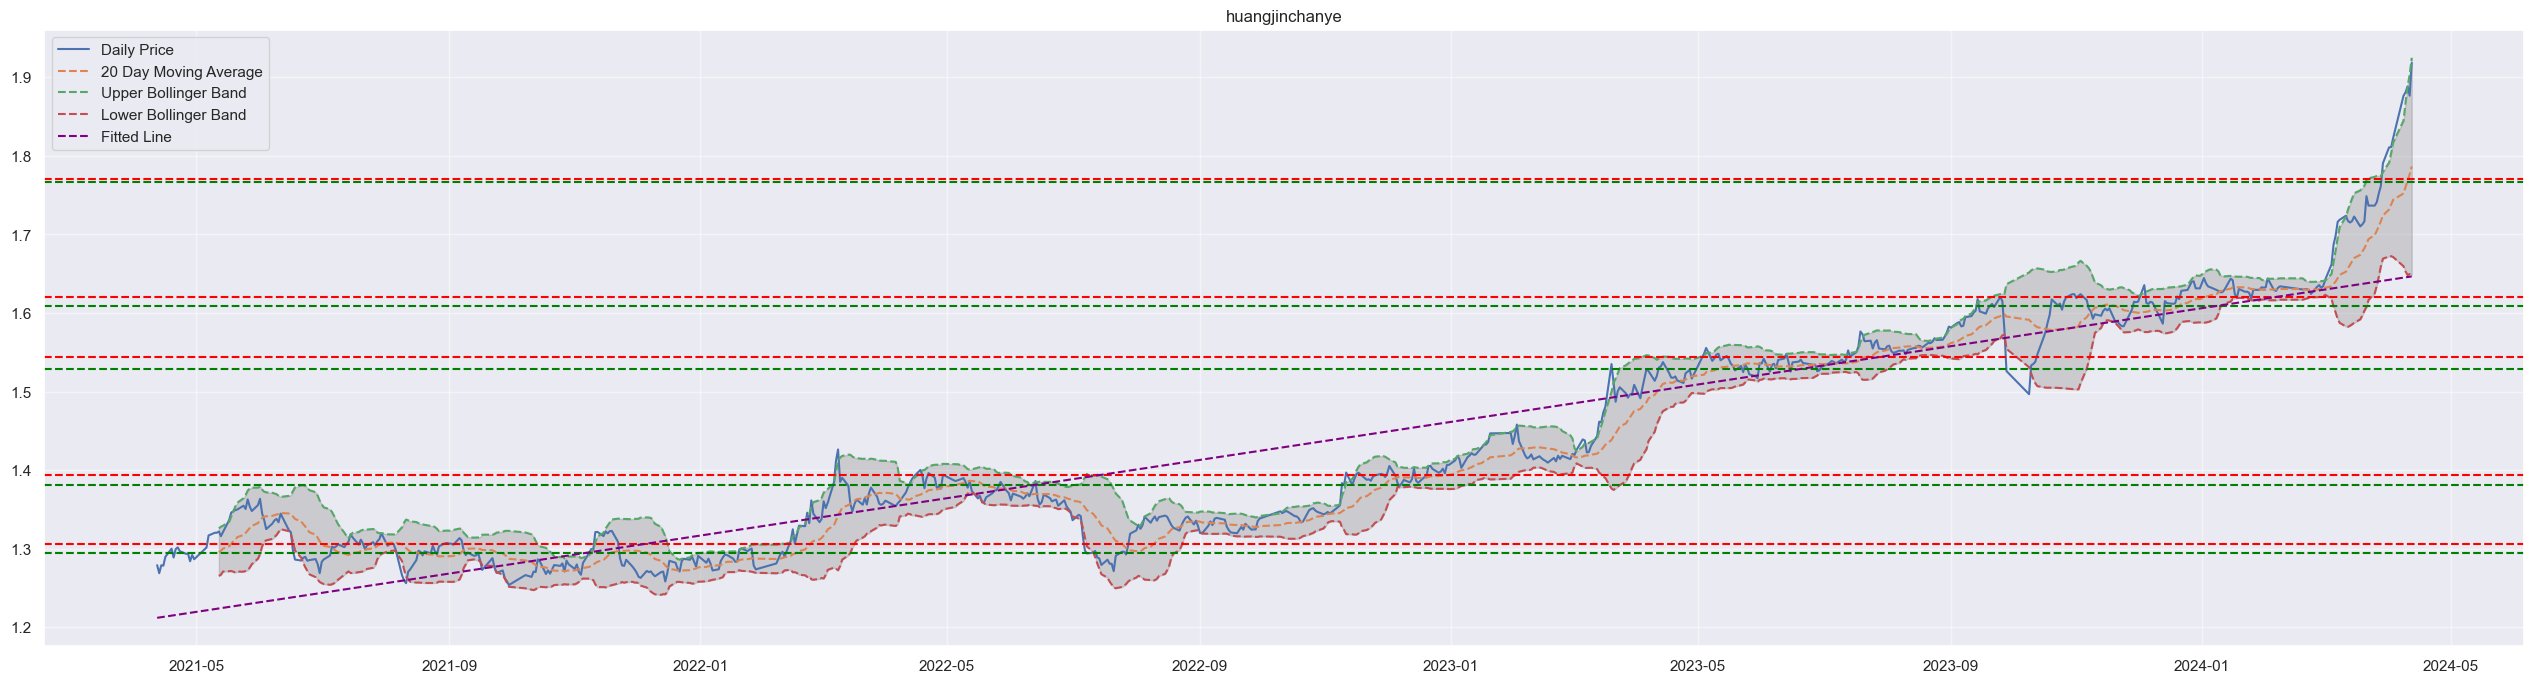

In [40]:
stock_df = df_fund[df_fund["name"]=='huangjinchanye']
start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d')
# start=df_fund['date'].min()

df = stock_df[stock_df['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
df = df.sort_values(by='date').reset_index()
df['daily_price'] = df['NAV']

print(datetime.today().strftime('%Y-%m-%d'))
print('* previous stock price closing', round(df.iloc[-1]['daily_price'],2))

# Support and Resistance
df = identify_weak_support_resistance(df)
low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"daily_price"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"daily_price"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

df['20 Day MA'] = df['NAV'].rolling(window=20).mean()
df['20 Day STD'] = df['NAV'].rolling(window=20).std()
    
# Calculate upper and lower bands
df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])

fig, ax = plt.subplots(figsize=(32,8))

# fit a trend line
df['date_numeric'] = pd.to_numeric(df['date'])
X = df['date_numeric'].values.reshape(-1, 1)  # Feature matrix (date)
y = df['NAV'].values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]

print("Annual return rate:", (X_b.dot(theta_best)[-1]-X_b.dot(theta_best)[0])[0]/((datetime.today()-pd.to_datetime(start)).days/365.2425))
# All time: Annual return rate: 0.07699482486915966

ax.grid(True, alpha=0.5)
ax.set_title(stock_df['name'].unique()[0])
ax.plot(df['date'], df['NAV'], label='Daily Price')
ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
ax.plot(df['date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
ax.plot(df['date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
ax.fill_between(df['date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')
    
ax.plot(df['date'], X_b.dot(theta_best), ls='--', color='purple', label='Fitted Line')
ax.legend()
ax.grid(True)

### Conclusion:
* 红利低波\红利 定投
* 通信设备、资源、传媒 网格
* 黄金产业 allin

In [41]:
def test_grid(stock_list, th1, th2, m, start_date='2021-01-01'):
    today_date = datetime.today().strftime('%Y-%m-%d')
    initial_cash = 10000
    investment = 1000
    list_stock = []
    list_profit = []
    list_max_loss = []
    list_number_actions = []
    list_minimal_cash_reserve = []
    list_price_change = []
#     for stock_name in dict_gridgood_2021:
    for stock_name in stock_list:
        stock_df = df_fund[df_fund["name"]==stock_name].sort_values(by='date').reset_index()[['date','NAV']].rename(columns={'NAV':'daily_price'})
        result = stock_trading_strategy(stock_df, start_date, today_date, initial_cash, investment, th1, th2, m)
        profit = ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-initial_cash)
        underlying_stock_price_change = (result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']
        max_loss = (result['total_stock_value']+result['total_cash']).min() - initial_cash
        number_actions = result[result['action'].isin(['Purchase','Sell'])].shape[0]
        minimal_cash_reserve = result['total_cash'].min()
        list_stock.append(stock_name)
        list_profit.append(profit)
        list_price_change.append(underlying_stock_price_change)
        list_max_loss.append(max_loss)
        list_minimal_cash_reserve.append(minimal_cash_reserve)
        list_number_actions.append(number_actions)

    df_all_stock = pd.DataFrame(
        {
            'stock_name': list_stock,
            'start_date': [start_date]*len(list_stock),
            'end_date': [today_date]*len(list_stock),
            'initial_cash': [initial_cash]*len(list_stock),
            'investment': [investment]*len(list_stock),
            'buy_threshold': [th1]*len(list_stock),
            'sell_threshold': [th2]*len(list_stock),
            'multiplier': [m]*len(list_stock),
            'profit': list_profit,
            'underlying_stock_price_change': list_price_change,
            'max_loss': list_max_loss,
            'minimal_cash_reserve': list_minimal_cash_reserve,
            'number_actions': list_number_actions
        }
    )
    print('Numbers of stock tested:', len(list_stock))
    print(df_all_stock.shape)
    return df_all_stock

In [42]:
strategy_dfs_2021 = []
for th1 in [0.05, 0.07, 0.1]:
    for th2 in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
        for m in [1, 1.05]:
            df_strategy = test_grid(list(dict_gridgood_2021.keys()), th1, th2, m)
            strategy_dfs_2021.append(df_strategy)

Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
N

In [43]:
good_dfs_2021 = []
for df in strategy_dfs_2021:
    good_dfs_2021.append(df[(df['profit']>=1000)&(df['max_loss']>=-1000)])
good_df_2021 = pd.concat(good_dfs_2021)
print(good_df_2021.shape)
good_df_2021.head()

(38, 13)


stock_name  start_date    end_date  initial_cash  investment  \
5  tongxinshebei  2021-01-01  2024-04-12         10000        1000   
5  tongxinshebei  2021-01-01  2024-04-12         10000        1000   
5  tongxinshebei  2021-01-01  2024-04-12         10000        1000   
5  tongxinshebei  2021-01-01  2024-04-12         10000        1000   
5  tongxinshebei  2021-01-01  2024-04-12         10000        1000   

   buy_threshold  sell_threshold  multiplier       profit  \
5           0.05            0.05        1.00  1733.712887   
5           0.05            0.05        1.05  2227.771519   
5           0.05            0.10        1.00  1781.856635   
5           0.05            0.10        1.05  2178.923078   
5           0.05            0.15        1.00  2460.234380   

   underlying_stock_price_change    max_loss  minimal_cash_reserve  \
5                       0.071615 -607.268649           4393.187923   
5                       0.071615 -707.911907           3288.230753   
5                       0.071615 -713.175903           4308.625447   
5                       0.071615 -806.701204           3248.314818   
5                       0.071615 -732.457151           4321.106070   

   number_actions  
5              58  
5              58  
5              32  
5              32  
5              30

In [44]:
good_df_2021[["stock_name", "underlying_stock_price_change"]].drop_duplicates()

stock_name  underlying_stock_price_change
5   tongxinshebei                       0.071615
10       chuanmei                      -0.164910

In [45]:
good_df_2021[
  (good_df_2021['max_loss']>=-1000)
  &
  (good_df_2021['profit']>1000)
][["stock_name", "buy_threshold", "sell_threshold", "multiplier", "profit", "max_loss", "minimal_cash_reserve"]].sort_values(by='profit', ascending=False)

stock_name  buy_threshold  sell_threshold  multiplier       profit  \
5   tongxinshebei           0.05            0.25        1.05  3243.793871   
5   tongxinshebei           0.05            0.15        1.05  2915.004478   
5   tongxinshebei           0.05            0.25        1.00  2703.287287   
5   tongxinshebei           0.05            0.20        1.05  2656.247055   
5   tongxinshebei           0.05            0.15        1.00  2460.234380   
5   tongxinshebei           0.07            0.25        1.05  2258.795019   
5   tongxinshebei           0.05            0.05        1.05  2227.771519   
5   tongxinshebei           0.05            0.20        1.00  2221.923667   
5   tongxinshebei           0.05            0.10        1.05  2178.923078   
5   tongxinshebei           0.07            0.30        1.05  2035.007156   
5   tongxinshebei           0.07            0.20        1.05  2018.794413   
10       chuanmei           0.07            0.10        1.05  1987.595353   
5   tongxinshebei           0.07            0.25        1.00  1973.856548   
5   tongxinshebei           0.07            0.15        1.05  1822.170004   
5   tongxinshebei           0.07            0.30        1.00  1783.596742   
5   tongxinshebei           0.05            0.10        1.00  1781.856635   
5   tongxinshebei           0.07            0.20        1.00  1773.935904   
5   tongxinshebei           0.05            0.05        1.00  1733.712887   
10       chuanmei           0.10            0.25        1.05  1683.489320   
10       chuanmei           0.07            0.10        1.00  1623.644405   
5   tongxinshebei           0.07            0.15        1.00  1619.877015   
5   tongxinshebei           0.07            0.10        1.05  1587.892595   
5   tongxinshebei           0.10            0.25        1.05  1515.915222   
5   tongxinshebei           0.10            0.30        1.05  1469.170088   
10       chuanmei           0.10            0.25        1.00  1445.710628   
5   tongxinshebei           0.10            0.15        1.05  1445.697674   
5   tongxinshebei           0.07            0.05        1.05  1434.218127   
5   tongxinshebei           0.07            0.10        1.00  1388.291122   
5   tongxinshebei           0.10            0.25        1.00  1386.148623   
5   tongxinshebei           0.10            0.15        1.00  1342.860053   
5   tongxinshebei           0.10            0.30        1.00  1339.562903   
5   tongxinshebei           0.10            0.20        1.05  1331.309378   
5   tongxinshebei           0.07            0.05        1.00  1269.771545   
5   tongxinshebei           0.10            0.20        1.00  1219.382983   
10       chuanmei           0.10            0.05        1.05  1202.572542   
10       chuanmei           0.10            0.10        1.05  1137.385407   
10       chuanmei           0.10            0.05        1.00  1055.587493   
5   tongxinshebei           0.10            0.05        1.05  1050.097019   

      max_loss  minimal_cash_reserve  
5  -845.608287           3489.345214  
5  -779.750151           3560.754553  
5  -796.928483           4251.599634  
5  -904.336064           3430.617438  
5  -732.457151           4321.106070  
5  -883.704986           4474.368750  
5  -707.911907           3288.230753  
5  -847.659744           4200.868373  
5  -806.701204           3248.314818  
5  -883.704986           4474.368750  
5  -623.790163           4710.422899  
10 -982.523243           2503.959602  
5  -833.082154           5000.000000  
5  -687.352791           4646.860272  
5  -833.082154           5000.000000  
5  -713.175903           4308.625447  
5  -597.957919           5214.108071  
5  -607.268649           4393.187923  
10 -982.281671           4776.395221  
10 -930.904538           3561.779904  
5  -655.611095           5156.454895  
5  -624.636441           4710.326314  
5  -634.118427           5689.875000  
5  -634.118427           5689.875000  
10 -929.477310           527

In [46]:
good_df_2021[
  (good_df_2021['max_loss']>=-1000)
  &
  (good_df_2021['profit']>1500)
][["stock_name", "buy_threshold", "sell_threshold", "multiplier", "profit", "max_loss", "minimal_cash_reserve"]].sort_values(by='profit', ascending=False)

stock_name  buy_threshold  sell_threshold  multiplier       profit  \
5   tongxinshebei           0.05            0.25        1.05  3243.793871   
5   tongxinshebei           0.05            0.15        1.05  2915.004478   
5   tongxinshebei           0.05            0.25        1.00  2703.287287   
5   tongxinshebei           0.05            0.20        1.05  2656.247055   
5   tongxinshebei           0.05            0.15        1.00  2460.234380   
5   tongxinshebei           0.07            0.25        1.05  2258.795019   
5   tongxinshebei           0.05            0.05        1.05  2227.771519   
5   tongxinshebei           0.05            0.20        1.00  2221.923667   
5   tongxinshebei           0.05            0.10        1.05  2178.923078   
5   tongxinshebei           0.07            0.30        1.05  2035.007156   
5   tongxinshebei           0.07            0.20        1.05  2018.794413   
10       chuanmei           0.07            0.10        1.05  1987.595353   
5   tongxinshebei           0.07            0.25        1.00  1973.856548   
5   tongxinshebei           0.07            0.15        1.05  1822.170004   
5   tongxinshebei           0.07            0.30        1.00  1783.596742   
5   tongxinshebei           0.05            0.10        1.00  1781.856635   
5   tongxinshebei           0.07            0.20        1.00  1773.935904   
5   tongxinshebei           0.05            0.05        1.00  1733.712887   
10       chuanmei           0.10            0.25        1.05  1683.489320   
10       chuanmei           0.07            0.10        1.00  1623.644405   
5   tongxinshebei           0.07            0.15        1.00  1619.877015   
5   tongxinshebei           0.07            0.10        1.05  1587.892595   
5   tongxinshebei           0.10            0.25        1.05  1515.915222   

      max_loss  minimal_cash_reserve  
5  -845.608287           3489.345214  
5  -779.750151           3560.754553  
5  -796.928483           4251.599634  
5  -904.336064           3430.617438  
5  -732.457151           4321.106070  
5  -883.704986           4474.368750  
5  -707.911907           3288.230753  
5  -847.659744           4200.868373  
5  -806.701204           3248.314818  
5  -883.704986           4474.368750  
5  -623.790163           4710.422899  
10 -982.523243           2503.959602  
5  -833.082154           5000.000000  
5  -687.352791           4646.860272  
5  -833.082154           5000.000000  
5  -713.175903           4308.625447  
5  -597.957919           5214.108071  
5  -607.268649           4393.187923  
10 -982.281671           4776.395221  
10 -930.904538           3561.779904  
5  -655.611095           5156.454895  
5  -624.636441           4710.326314  
5  -634.118427           5689.875000

In [47]:
strategy_dfs_2022 = []
for th1 in [0.05, 0.07, 0.1]:
    for th2 in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
        for m in [1, 1.05]:
            df_strategy = test_grid(list(dict_gridgood_2022.keys()), th1, th2, m, start_date='2022-01-01')
            strategy_dfs_2022.append(df_strategy)

Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
Numbers of stock tested: 13
(13, 13)
N

In [48]:
good_dfs_2022 = []
for df in strategy_dfs_2022:
    good_dfs_2022.append(df[(df['profit']>=1000)&(df['max_loss']>=-1000)])
good_dfs_2022 = pd.concat(good_dfs_2022)
print(good_dfs_2022.shape)
good_dfs_2022.head()

(28, 13)


stock_name  start_date    end_date  initial_cash  investment  \
6         ziyuan  2022-01-01  2024-04-12         10000        1000   
6         ziyuan  2022-01-01  2024-04-12         10000        1000   
5    yousejinshu  2022-01-01  2024-04-12         10000        1000   
7  tongxinshebei  2022-01-01  2024-04-12         10000        1000   
7  tongxinshebei  2022-01-01  2024-04-12         10000        1000   

   buy_threshold  sell_threshold  multiplier       profit  \
6           0.05            0.05        1.00  1000.496113   
6           0.05            0.05        1.05  1042.860225   
5           0.05            0.15        1.00  1146.420696   
7           0.07            0.05        1.00  1093.234865   
7           0.07            0.05        1.05  1257.530123   

   underlying_stock_price_change    max_loss  minimal_cash_reserve  \
6                       0.084608  -79.972357           7667.648059   
6                       0.084608  -80.730651           7534.738942   
5                      -0.106011 -982.564025           2630.984028   
7                       0.016479 -927.537576           5000.000000   
7                       0.016479 -982.683052           4474.368750   

   number_actions  
6              34  
6              34  
5              19  
7              35  
7              35

In [49]:
good_dfs_2022[["stock_name", "underlying_stock_price_change"]].drop_duplicates()

stock_name  underlying_stock_price_change
6          ziyuan                       0.084608
5     yousejinshu                      -0.106011
7   tongxinshebei                       0.016479
12       chuanmei                      -0.183445

In [50]:
good_dfs_2022[
  (good_dfs_2022['max_loss']>=-1000)
  &
  (good_dfs_2022['profit']>1000)
][["stock_name", "buy_threshold", "sell_threshold", "multiplier", "profit", "max_loss", "minimal_cash_reserve"]].sort_values(by='profit', ascending=False)

stock_name  buy_threshold  sell_threshold  multiplier       profit  \
7   tongxinshebei           0.07            0.30        1.05  2341.847363   
7   tongxinshebei           0.07            0.25        1.05  2046.951812   
7   tongxinshebei           0.07            0.15        1.05  2039.057403   
7   tongxinshebei           0.07            0.30        1.00  2009.027262   
7   tongxinshebei           0.07            0.20        1.05  1776.449256   
7   tongxinshebei           0.07            0.25        1.00  1755.721746   
7   tongxinshebei           0.07            0.15        1.00  1736.022784   
7   tongxinshebei           0.07            0.10        1.05  1709.659834   
7   tongxinshebei           0.10            0.30        1.05  1554.035355   
7   tongxinshebei           0.07            0.20        1.00  1527.555301   
7   tongxinshebei           0.07            0.10        1.00  1482.643460   
7   tongxinshebei           0.10            0.30        1.00  1395.965333   
7   tongxinshebei           0.10            0.25        1.05  1373.909379   
7   tongxinshebei           0.10            0.15        1.05  1322.750222   
7   tongxinshebei           0.07            0.05        1.05  1257.530123   
7   tongxinshebei           0.10            0.25        1.00  1234.265857   
7   tongxinshebei           0.10            0.15        1.00  1208.341431   
7   tongxinshebei           0.10            0.20        1.05  1170.031506   
5     yousejinshu           0.05            0.15        1.00  1146.420696   
7   tongxinshebei           0.10            0.10        1.05  1132.058058   
5     yousejinshu           0.07            0.20        1.05  1098.285047   
7   tongxinshebei           0.07            0.05        1.00  1093.234865   
12       chuanmei           0.10            0.05        1.05  1087.197573   
7   tongxinshebei           0.10            0.10        1.00  1062.780461   
5     yousejinshu           0.10            0.30        1.05  1053.473372   
7   tongxinshebei           0.10            0.20        1.00  1052.552605   
6          ziyuan           0.05            0.05        1.05  1042.860225   
6          ziyuan           0.05            0.05        1.00  1000.496113   

      max_loss  minimal_cash_reserve  
7  -982.683052           4474.368750  
7  -982.683052           4474.368750  
7  -982.683052           4474.368750  
7  -927.537576           5000.000000  
7  -982.683052           4474.368750  
7  -927.537576           5000.000000  
7  -927.537576           5000.000000  
7  -982.683052           4474.368750  
7  -779.074665           5689.875000  
7  -927.537576           5000.000000  
7  -927.537576           5000.000000  
7  -748.424293           6000.000000  
7  -779.074665           5689.875000  
7  -779.074665           5689.875000  
7  -982.683052           4474.368750  
7  -748.424293           6000.000000  
7  -748.424293           6000.000000  
7  -779.074665           5689.875000  
5  -982.564025           2630.984028  
7  -779.074665           5689.875000  
5  -857.981419           3671.652199  
7  -927.537576           5000.000000  
12 -977.895028           4668.649828  
7  -748.424293           6000.000000  
5  -658.803843           4813.869256  
7  -748.424293           6000.000000  
6   -80.730651           7534.738942  
6   -79.972357           7667.648059

2024-04-12
* previous stock price closing 1.11
[[0.82043548]
 [0.90902917]
 [0.98915882]
 [1.06255897]
 [1.17591667]]
[[0.84474375]
 [0.92966136]
 [1.00637292]
 [1.08552045]
 [1.21635385]]
Latest 20 Day MA: 1.139665
Latest Lower Bollinger Band: 1.0564384537542375
Latest Higher Bollinger Band: 1.2228915462457624


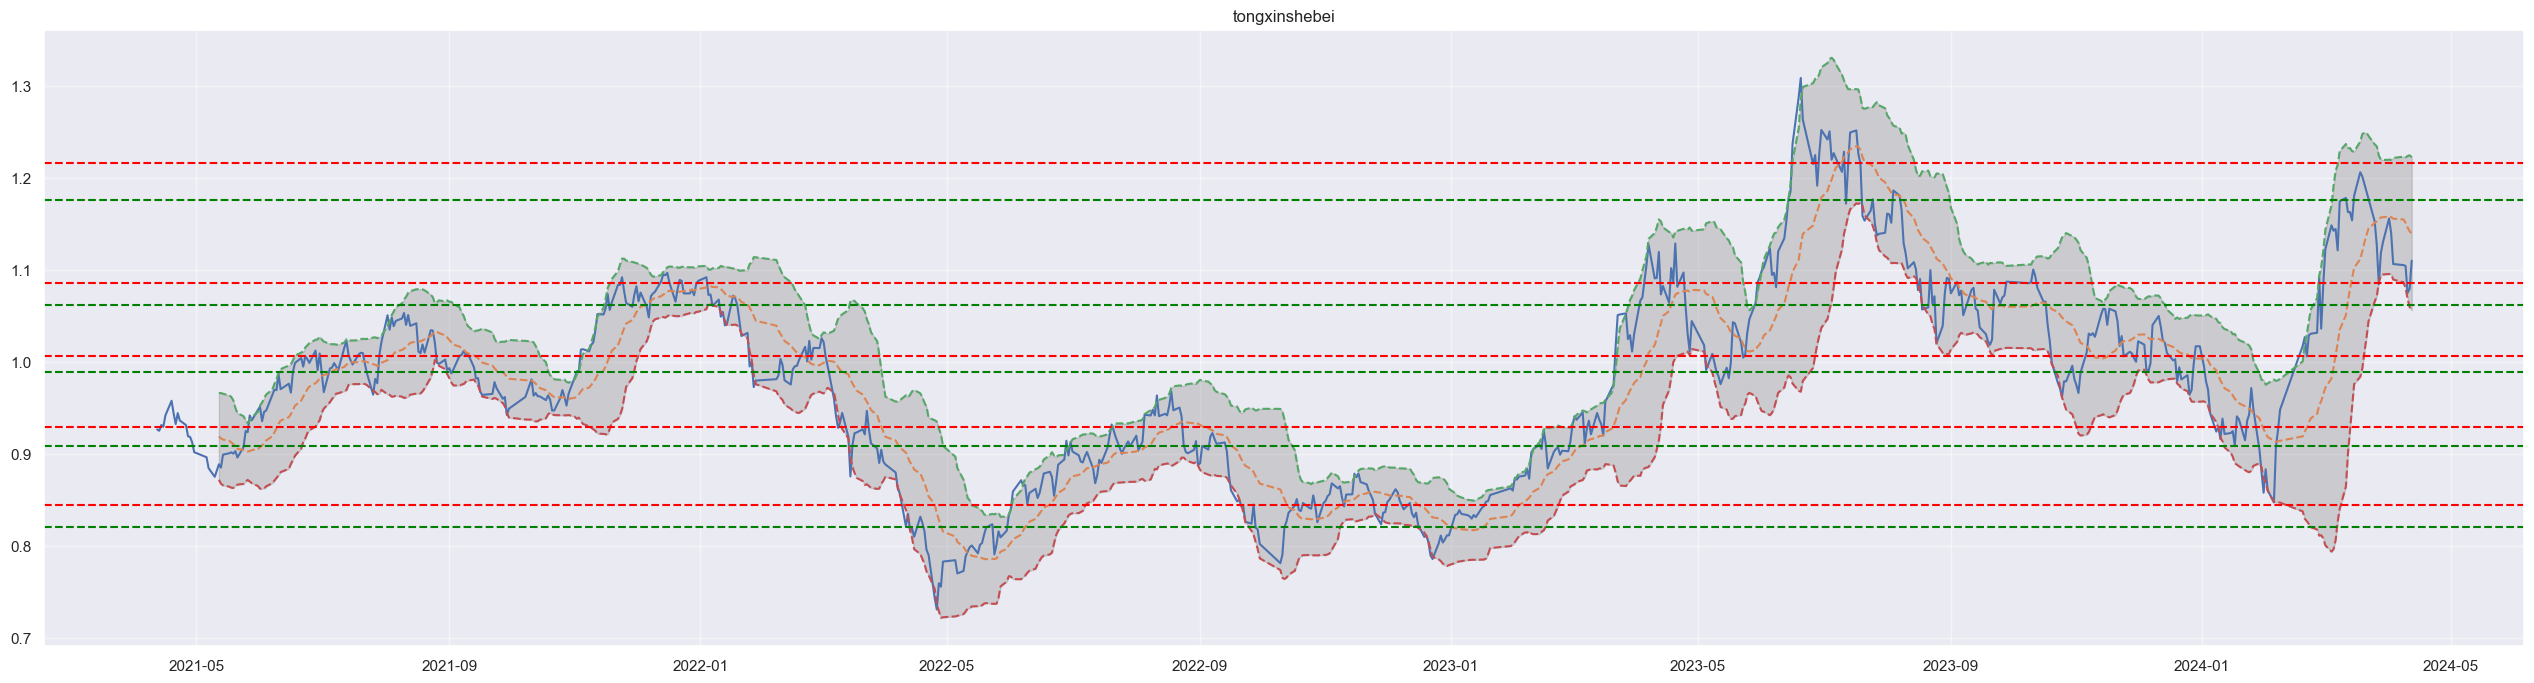

In [51]:
# begin buy 1.06
stock_bollinger_move(df_fund[df_fund["name"]=='tongxinshebei'])